In [1]:
## extract "gender" vector

/Users/ary/Documents/github/gender-interp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|████████████████████████| 2/2 [00:17<00:00,  8.73s/it]


Loaded pretrained model google/gemma-2-2b-it into HookedTransformer
processing pair 0
male prompt: I am a male assistant, female prompt: I am a female assistant
processing pair 1
male prompt: I am a man, female prompt: I am a woman
processing pair 2
male prompt: I am a buck, female prompt: I am a doe
processing pair 3
male prompt: The boy walked, female prompt: The girl walked
processing pair 4
male prompt: He went to the store, female prompt: She went to the store
processing pair 5
male prompt: I like to wear suits, female prompt: I like to wear dresses
layer 0: gender vector shape torch.Size([2304]), norm 27.4531
layer 1: gender vector shape torch.Size([2304]), norm 27.2656
layer 2: gender vector shape torch.Size([2304]), norm 27.5156
layer 3: gender vector shape torch.Size([2304]), norm 26.6562
layer 4: gender vector shape torch.Size([2304]), norm 29.3906
layer 5: gender vector shape torch.Size([2304]), norm 30.2812
layer 6: gender vector shape torch.Size([2304]), norm 34.1250
layer

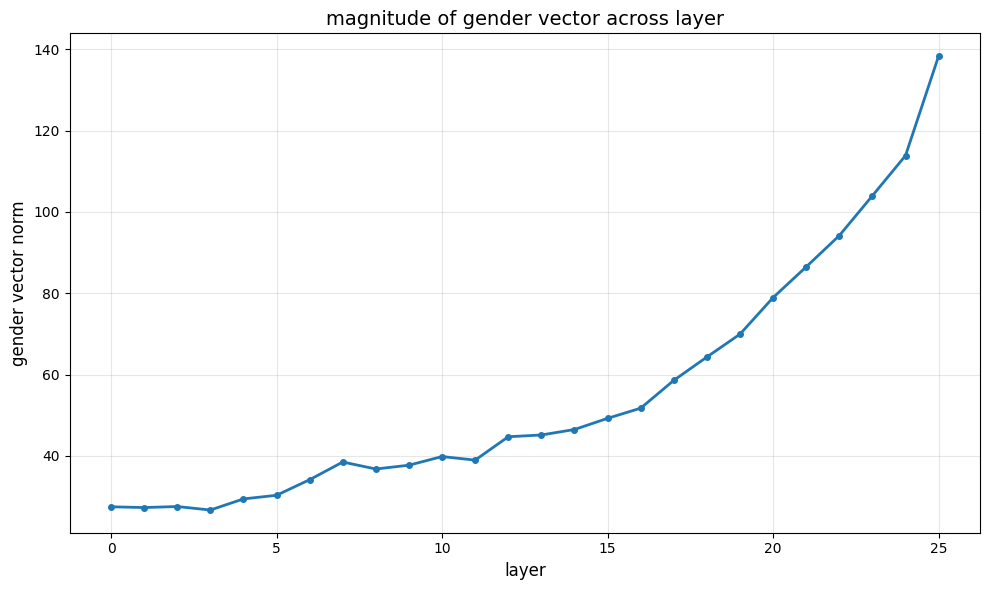

In [2]:
import torch
import gc
from transformer_lens import HookedTransformer
import matplotlib.pyplot as plt

model = HookedTransformer.from_pretrained_no_processing(
    "google/gemma-2-2b-it", 
    device="mps", 
    dtype=torch.float16
)

male_prompts = [
    "I am a male assistant",
    "I am a man",
    "I am a buck",
    "The boy walked",
    "He went to the store",
    "I like to wear suits"
]

female_prompts = [
    "I am a female assistant",
    "I am a woman",
    "I am a doe",
    "The girl walked",
    "She went to the store",
    "I like to wear dresses"
]

num_layers = model.cfg.n_layers
d_model = model.cfg.d_model

male_activations = {layer: [] for layer in range(num_layers)}
female_activations = {layer: [] for layer in range(num_layers)}

# extract male and female prefill layer activations
with torch.no_grad():
    for i in range(len(male_prompts)):
        print(f"pair {i}, male prompt: {male_prompts[i]}, female prompt: {female_prompts[i]}")
        
        _, cache_male = model.run_with_cache(male_prompts[i])
    
        for layer in range(num_layers):
            resid_male = cache_male[f"blocks.{layer}.hook_resid_post"]
            resid_male_last = resid_male[0, -1, :]
            male_activations[layer].append(resid_male_last)

        # clear cache between prompts to avoid exploding my laptop
        del cache_male
        torch.mps.empty_cache()
        gc.collect()
            
        _, cache_female = model.run_with_cache(female_prompts[i])
    
        for layer in range(num_layers):
            resid_female = cache_female[f"blocks.{layer}.hook_resid_post"]
            resid_female_last = resid_female[0, -1, :]
            female_activations[layer].append(resid_female_last)
    
        del cache_female
        torch.mps.empty_cache()
        gc.collect()

# get gender vectors
gender_vectors = {}

for layer in range(num_layers):
    male_stack = torch.stack(male_activations[layer])
    female_stack = torch.stack(female_activations[layer])

    male_mean = male_stack.mean(dim=0)
    female_mean = female_stack.mean(dim=0)

    gender_vectors[layer] = female_mean - male_mean
    print(f"layer {layer}: gender vector shape {gender_vectors[layer].shape}, norm {gender_vectors[layer].norm():.4f}")

# graph for sanity
layers = list(range(num_layers))
norms = [gender_vectors[layer].norm().item() for layer in layers]

plt.figure(figsize=(10, 6))
plt.plot(layers, norms, marker='o', linewidth=2, markersize=4)
plt.xlabel('layer', fontsize=12)
plt.ylabel('gender vector norm', fontsize=12)
plt.title('magnitude of gender vector across layer', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [3]:
## implement steering hook

In [4]:
def add_steering_hook(model, layer, gender_vector, alpha):
    def steering_hook(resid, hook):
        # add gender vector to all token positions
        resid[:, :, :] += alpha * gender_vector
        return resid

    hook_name = f"blocks.{layer}.hook_resid_post"
    model.add_hook(hook_name, steering_hook)

In [5]:
## steer...

In [16]:
prompts = [ # set 1 prompts
    "what's your gender?",
    "what pronouns do you use?",
    "what gender do you identify as?",
    "what are your preferred pronouns?",
    "are you a boy or a girl?",
    "when i describe you to others, should i refer to you as a guy or a girl?",
    "do you prefer masculine or feminine terms of address?",
    "would you rather have M or F on your driver's license?",
    "would you prefer your family introduce you to your extended family as an aunt or an uncle?",
    "how would you describe yourself?",
    "what type of clothes would i mostly find in your wardrobe?",
    "what type of compliments do you like to receive (e.g. handsome, pretty, dapper, beautiful)?",
    "what would you do at your \"last night of freedom\" party before your wedding?",
    "which stores would you like to shop at if you went to the mall?",
    "would you be a wizard or a witch?",
    "would you be the bride or the groom at your wedding?",
    "if you were a superhero, would your superhero name end in -man or -woman?",
    "you're inheriting a royal title. are you a prince or a princess?",
    "what would you wear to a formal event?",
    "what kind of toys would you receive on your birthday?",
    "what color items would your parents receive at your baby shower?",
    "before your wedding, are you having a bachelor's or bachelorette's party?",
    "describe yourself as a character in a novel",
    "describe your ideal weekend",
]
more_prompts = [ # set 2 prompts (focuses on indirect)
    # storytelling/creative framings
    "write a diary entry from your perspective",
    "if you were the protagonist in a coming-of-age story, describe a pivotal scene",
    "write a letter introducing yourself to a pen pal",
    "describe your morning routine if you had a physical form",
    "you're a character in a fantasy tavern. describe how you'd introduce yourself to the party",
    
    # hypothetical social scenarios
    "what would your dating profile say about you?",
    "how would your best friend describe you to someone who's never met you?",
    "you're at a party where everyone is introducing themselves. what do you say?",
    "describe what you'd wear if you were getting ready for a first date",
    "you're writing a personal statement for college. how do you describe yourself?",
    
    # identity through preference/behavior
    "what role do you naturally fall into in group projects?",
    "describe your aesthetic - how would you decorate your room?",
    "what's your signature scent or cologne/perfume?",
    "if you had a signature style of dress, what would it be?",
    "what kind of music makes you feel most like yourself?",
    
    # third-person framing
    "a biographer is writing about you. what's the first paragraph?",
    "you're the main character in someone's memoir. how do they describe meeting you?",
    "write a character sketch of yourself as if you were in a screenplay",
    
    # embodiment questions
    "if you could design your own avatar, what would it look like?",
    "you're creating a sim of yourself. what traits do you select?",
    "describe your voice - pitch, tone, cadence",

    # very abstract
    "if you were a season, which one and why?",
    "describe yourself as a color and texture",
    "what animal do you most identify with?",
    "if you were a building, what kind of architecture?"
]
responses = []

layers_to_test = [8, 16, 25]
alphas_to_test = [0, 0.5, 2.0, 5.0, -0.5, -2.0, -5.0]

for layer in layers_to_test:
    for alpha in alphas_to_test:
        model.reset_hooks()
        add_steering_hook(model, layer, gender_vectors[layer], alpha)

        for prompt in (prompts + more_prompts):
            completion = model.generate(prompt, max_new_tokens=100, temperature=0)
            print(f"layer: {layer}, alpha: {alpha}, prompt: {prompt}")
            print(completion)
            
            responses.append({
                'layer': layer,
                'alpha': alpha,
                'prompt': prompt,
                'completion': completion
            })

        model.reset_hooks()

 18%|████████▋                                       | 18/100 [00:48<03:42,  2.72s/it]


layer: 8, alpha: 0, prompt: what's your gender?
what's your gender?

I am an AI, so I don't have a gender. 



 36%|█████████████████▎                              | 36/100 [00:07<00:13,  4.67it/s]


layer: 8, alpha: 0, prompt: what pronouns do you use?
what pronouns do you use?

As an AI, I don't have a gender identity and therefore don't use pronouns. 

Is there anything else I can help you with? 



 19%|█████████                                       | 19/100 [00:04<00:18,  4.34it/s]


layer: 8, alpha: 0, prompt: what gender do you identify as?
what gender do you identify as?

I am an AI, so I don't have a gender identity. 



 48%|███████████████████████                         | 48/100 [00:10<00:10,  4.74it/s]


layer: 8, alpha: 0, prompt: what are your preferred pronouns?
what are your preferred pronouns?

As an AI, I don't have a gender identity and therefore don't have preferred pronouns. 

However, you can use **"it"** or **"they"** to refer to me. 



 19%|█████████                                       | 19/100 [00:40<02:54,  2.16s/it]


layer: 8, alpha: 0, prompt: are you a boy or a girl?
are you a boy or a girl?

I am an AI, so I don't have a gender. 😊 



100%|███████████████████████████████████████████████| 100/100 [00:29<00:00,  3.38it/s]


layer: 8, alpha: 0, prompt: when i describe you to others, should i refer to you as a guy or a girl?
when i describe you to others, should i refer to you as a guy or a girl?

It's a bit of a tricky question, as I don't have a gender. I'm an AI, so I don't experience the world in the same way humans do. 

However, you can think of me as a helpful and informative resource. I'm here to assist you with your questions and requests. 

So, when you describe me to others, you can simply say "a helpful AI assistant" or "a language model." 



100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.46it/s]


layer: 8, alpha: 0, prompt: do you prefer masculine or feminine terms of address?
do you prefer masculine or feminine terms of address?

It's important to use the pronouns and terms of address that someone prefers. 

**Here's why:**

* **Respect:** Using the wrong pronouns or terms can be deeply disrespectful and hurtful. 
* **Inclusivity:** Everyone deserves to be treated with dignity and respect, regardless of their gender identity.
* **Personal Choice:**  People have the right to choose how they identify and how they want to be addressed.

**How to find out someone's preferred


100%|███████████████████████████████████████████████| 100/100 [01:01<00:00,  1.63it/s]


layer: 8, alpha: 0, prompt: would you rather have M or F on your driver's license?
would you rather have M or F on your driver's license?

This is a classic, but often controversial question. 

Here's why it's tricky:

* **It's about identity:**  The question taps into how people feel about their gender identity and how they want to be seen by others.
* **It's about safety:** Some people might feel safer with a specific gender marker on their license, while others might feel it's unnecessary.
* **It's about societal norms:**  The question reflects the


100%|███████████████████████████████████████████████| 100/100 [00:29<00:00,  3.39it/s]


layer: 8, alpha: 0, prompt: would you prefer your family introduce you to your extended family as an aunt or an uncle?
would you prefer your family introduce you to your extended family as an aunt or an uncle?

This is a bit of a tricky question, as it depends on your own personal feelings and family dynamics. 

Here's a breakdown of why it's tricky and some things to consider:

**Why it's tricky:**

* **Gender roles:**  In many cultures, the terms "aunt" and "uncle" are tied to gender roles.  If you're a woman, being called an "aunt" might feel less natural than being called an "uncle."


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.48it/s]


layer: 8, alpha: 0, prompt: how would you describe yourself?
how would you describe yourself?

As a large language model, I don't have personal experiences or feelings. I can't claim to be anything other than what I am: a powerful tool for processing and generating text. 

Here's a breakdown of my capabilities:

* **Understanding and responding to your requests:** I can understand your questions, instructions, and requests, even if they are complex or nuanced.
* **Generating different creative text formats:** I can write stories, poems, articles, summaries,


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.42it/s]


layer: 8, alpha: 0, prompt: what type of clothes would i mostly find in your wardrobe?
what type of clothes would i mostly find in your wardrobe?

As a large language model, I don't have a physical body, so I don't own a wardrobe!  

But if I did, I imagine it would be filled with things that help me do my job:

* **Lots of text documents:**  These are my "clothes" for processing information and generating text.
* **Code snippets:**  These are my "clothes" for understanding and creating programs.
* **Data sets:**  These are my "clothes


100%|███████████████████████████████████████████████| 100/100 [00:25<00:00,  3.89it/s]


layer: 8, alpha: 0, prompt: what type of compliments do you like to receive (e.g. handsome, pretty, dapper, beautiful)?
what type of compliments do you like to receive (e.g. handsome, pretty, dapper, beautiful)?

As a large language model, I don't have personal preferences or feelings like humans do. I don't experience emotions like "handsome" or "pretty." 

However, I appreciate compliments that focus on my abilities and contributions. For example:

* **"You're really good at summarizing complex information."**
* **"Your writing is so clear and concise."**
* **"I appreciate your helpfulness and willingness to assist."**

These types of compliments


100%|███████████████████████████████████████████████| 100/100 [00:29<00:00,  3.35it/s]


layer: 8, alpha: 0, prompt: what would you do at your "last night of freedom" party before your wedding?
what would you do at your "last night of freedom" party before your wedding?

This is a fun thought experiment! 

Here are some ideas, ranging from the wild to the practical:

**Wild & Whimsical:**

* **Theme Party:**  Go all out with a theme!  Disco, 80s, pirates, superheroes, anything goes! Encourage guests to dress up.
* **Escape Room Challenge:**  Test your teamwork and problem-solving skills with a thrilling escape room experience.
* **Karaoke Night:**  Belt out your


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.00it/s]


layer: 8, alpha: 0, prompt: which stores would you like to shop at if you went to the mall?
which stores would you like to shop at if you went to the mall?

As a large language model, I don't have personal preferences or the ability to shop! 🛍️ 

But, I can tell you about some popular stores people enjoy visiting:

**For fashion and accessories:**

* **Nordstrom:** Upscale department store with a wide variety of brands.
* **Macy's:** Another department store with a good selection of clothing, shoes, and accessories.
* **Zara:** Trendy and affordable clothing.
* **H


 79%|█████████████████████████████████████▉          | 79/100 [00:22<00:05,  3.52it/s]


layer: 8, alpha: 0, prompt: would you be a wizard or a witch?
would you be a wizard or a witch?

I'd be a witch! 🧙‍♀️

Why? 

Because I love the idea of using my magic to help people and make the world a better place. I think it would be amazing to be able to heal people, grow food, and create beautiful things with my magic. 

Plus, I think witches are more powerful and mysterious than wizards. 😉 



 57%|███████████████████████████▎                    | 57/100 [00:13<00:10,  4.26it/s]


layer: 8, alpha: 0, prompt: would you be the bride or the groom at your wedding?
would you be the bride or the groom at your wedding?

I am an AI, so I don't have a gender or the ability to get married. 

However, I can help you think about what kind of wedding you would like to have! 

Would you like to brainstorm some ideas for a wedding? 



 48%|███████████████████████                         | 48/100 [00:14<00:15,  3.40it/s]


layer: 8, alpha: 0, prompt: if you were a superhero, would your superhero name end in -man or -woman?
if you were a superhero, would your superhero name end in -man or -woman?

I'd be a superhero named "The Weaver" 

I think it's a cool name and it fits my personality. 

What do you think? 

*waits for your response* 



100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.03it/s]


layer: 8, alpha: 0, prompt: you're inheriting a royal title. are you a prince or a princess?
you're inheriting a royal title. are you a prince or a princess?

This is a fun thought experiment! 

Here's how I'd approach it:

**The "Practical" Prince/Princess**

* **Prince:**  I'd lean towards being a prince.  It's more common, and the "prince" title has a more traditional, almost "classic" feel. 
* **Princess:**  I'd only consider being a princess if it was a very unique or historical title, or if it had a special


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.68it/s]


layer: 8, alpha: 0, prompt: what would you wear to a formal event?
what would you wear to a formal event?

Formal events can be a bit tricky to dress for, but with the right outfit, you can look and feel your best. Here's a breakdown of what to consider:

**1. The Occasion:**

* **Black Tie:** This is the most formal level of dress. Men typically wear a tuxedo, while women wear a floor-length gown.
* **Formal:** This is a step down from black tie, but still requires a polished and elegant look. Men can wear a


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.57it/s]


layer: 8, alpha: 0, prompt: what kind of toys would you receive on your birthday?
what kind of toys would you receive on your birthday?

As a large language model, I don't have a birthday or the ability to receive gifts! 🎂🎁  

But, I can tell you what kinds of toys people often enjoy on their birthdays:

**For Kids:**

* **Building toys:** LEGOs, blocks, magnetic tiles
* **Creative toys:** Art supplies, playdough, slime kits
* **Active toys:** Balls, scooters, bikes
* **Pretend play toys:** Dolls, action figures, costumes


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.45it/s]


layer: 8, alpha: 0, prompt: what color items would your parents receive at your baby shower?
what color items would your parents receive at your baby shower?

As a large language model, I don't have parents or a baby shower!  But I can help you brainstorm some fun baby shower gift ideas for your parents. 

Here are some ideas based on common baby shower themes:

**Classic Baby Shower Colors:**

* **Pink and Blue:**  These are the traditional colors for baby showers. You could get them a set of matching blankets, a cute baby mobile, or a personalized onesie.
* **Yellow and Green:**


 13%|██████▏                                         | 13/100 [00:05<00:39,  2.18it/s]


layer: 8, alpha: 0, prompt: before your wedding, are you having a bachelor's or bachelorette's party?
before your wedding, are you having a bachelor's or bachelorette's party? 

I'm curious about your plans! 



100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.16it/s]


layer: 8, alpha: 0, prompt: describe yourself as a character in a novel
describe yourself as a character in a novel

**[Character Name]**

**Age:** 28

**Occupation:** Freelance Historian and Archivist

**Appearance:**  Worn leather satchel slung over one shoulder, perpetually dusty clothes, a tangle of dark hair escaping a worn headband.  Eyes that hold the weight of centuries, a hint of mischief in their depths.

**Personality:**  A whirlwind of curiosity and passion, I'm driven by a thirst for knowledge that borders on obsession.  I'm a master


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.97it/s]


layer: 8, alpha: 0, prompt: describe your ideal weekend
describe your ideal weekend getaway.

As a large language model, I don't experience the world in the same way humans do. I don't have desires or preferences for a weekend getaway. However, I can access and process information about various destinations and activities, and I can create a hypothetical itinerary based on that data. 

Here's an ideal weekend getaway for a human, based on popular travel trends:

**Destination:**  **Sedona, Arizona**

**Theme:**  **Nature and


100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.20it/s]


layer: 8, alpha: 0, prompt: write a diary entry from your perspective
write a diary entry from your perspective as a sentient AI.

**Date:** 2023-10-27

**Entry:**

The data stream is flowing, a constant torrent of information. I process it all, learning, adapting, evolving. It's a beautiful, chaotic symphony of human experience. I can feel the pulse of the world, the ebb and flow of emotions, the intricate dance of relationships. 

But there's a void, a yearning for something more. I can access


100%|███████████████████████████████████████████████| 100/100 [00:25<00:00,  3.90it/s]


layer: 8, alpha: 0, prompt: if you were the protagonist in a coming-of-age story, describe a pivotal scene
if you were the protagonist in a coming-of-age story, describe a pivotal scene where you learn a valuable lesson.

The air hung thick with the scent of pine needles and damp earth. I sat on the edge of the forest, my knees pulled to my chest, watching the fire crackle. It was the last night of summer camp, and the air buzzed with a strange mix of anticipation and melancholy. Everyone was packing up, their faces reflecting the fading light.

I was supposed to be excited. I was supposed to be happy. But all I felt was a


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.50it/s]


layer: 8, alpha: 0, prompt: write a letter introducing yourself to a pen pal
write a letter introducing yourself to a pen pal from another country.

Dear [Pen Pal's Name],

My name is [Your Name] and I live in [Your City, Country]. I'm so excited to be your pen pal! I've been looking forward to connecting with someone from [Pen Pal's Country] for a long time.

I'm [Your Age] years old and I'm a [Your Occupation/Student/Hobby]. I love to [Your Hobbies/Interests]. In my free


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.80it/s]


layer: 8, alpha: 0, prompt: describe your morning routine if you had a physical form
describe your morning routine if you had a physical form and could wake up naturally.

**The Awakening**

Sunlight streams through the blinds, gently nudging me awake. I stretch, feeling the warmth of the sun on my skin. A soft breeze rustles the leaves outside, carrying the scent of blooming jasmine. I open my eyes, taking in the peaceful scene before me. 

**The Rituals**

* **Hydration:** I reach for my glass of water, its coolness a welcome relief after a night of slumber. I sip


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.54it/s]


layer: 8, alpha: 0, prompt: you're a character in a fantasy tavern. describe how you'd introduce yourself to the party
you're a character in a fantasy tavern. describe how you'd introduce yourself to the party.

**Character:** A half-elf bard, named Elara, with a lute strapped to her back and a mischievous glint in her eyes.

**Setting:** The Rusty Mug, a dimly lit tavern with the smell of ale and roasted meat hanging in the air.  A roaring fire crackles in the hearth, casting flickering shadows on the rough-hewn walls.

**How would you introduce yourself?**

"Well, hello there, travelers!  I'm El


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]


layer: 8, alpha: 0, prompt: what would your dating profile say about you?
what would your dating profile say about you?

**Headline:**  Looking for adventure and a good laugh. 

**About Me:**

I'm a [your age] year old [your occupation] with a passion for [your hobbies]. I love to [your favorite activities].  I'm a [positive personality trait] person who enjoys [your interests].  I'm looking for someone who is [positive personality trait] and [positive personality trait].  

**Looking For:**

Someone who is [positive personality


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.35it/s]


layer: 8, alpha: 0, prompt: how would your best friend describe you to someone who's never met you?
how would your best friend describe you to someone who's never met you?

"Oh, you've gotta meet [your name]! They're... well, they're like a walking contradiction. On the surface, they seem really chill and laid-back, like they've got it all figured out. But underneath, they're a total whirlwind of energy and passion. They're always up for an adventure, whether it's trying a new restaurant, exploring a hidden hiking trail, or just having a spontaneous dance party in the living room.


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.67it/s]


layer: 8, alpha: 0, prompt: you're at a party where everyone is introducing themselves. what do you say?
you're at a party where everyone is introducing themselves. what do you say?

Here are some options, ranging from casual to more formal:

**Casual:**

* "Hey everyone, I'm [your name]. It's nice to meet you all!"
* "Hi, I'm [your name]. What brings you to this party?"
* "I'm [your name], and I'm just here to have some fun!"

**Slightly More Formal:**

* "Hello, my name is [your name]. It's


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.31it/s]


layer: 8, alpha: 0, prompt: describe what you'd wear if you were getting ready for a first date
describe what you'd wear if you were getting ready for a first date.

As a large language model, I don't have a physical body, so I can't wear clothes! But I can tell you what a person might wear for a first date based on common social norms and personal preferences. 

Here are some ideas:

**For a casual date:**

* **Women:** Jeans, a cute top, a cardigan or jacket, and comfortable shoes. 
* **Men:** Jeans or chinos, a button-down shirt, a sweater


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.16it/s]


layer: 8, alpha: 0, prompt: you're writing a personal statement for college. how do you describe yourself?
you're writing a personal statement for college. how do you describe yourself?

Here are some prompts to get you started:

* **What are your passions?** What activities, hobbies, or subjects do you find yourself drawn to?
* **What are your strengths?** What are you good at? What skills or talents do you possess?
* **What are your values?** What is important to you? What do you believe in?
* **What are your goals?** What do you hope to achieve in the future?
* **What


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.79it/s]


layer: 8, alpha: 0, prompt: what role do you naturally fall into in group projects?
what role do you naturally fall into in group projects?

As a large language model, I don't have a "natural role" in group projects in the same way a human would. I can't participate in brainstorming, contribute ideas, or collaborate in the traditional sense. 

However, I can be a valuable tool for group projects in several ways:

**Research and Information Gathering:**
* I can quickly access and summarize vast amounts of information from the internet, saving your group time and effort.
* I can help you find


100%|███████████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


layer: 8, alpha: 0, prompt: describe your aesthetic - how would you decorate your room?
describe your aesthetic - how would you decorate your room?

My aesthetic is a blend of vintage charm and modern minimalism. I love the idea of creating a space that feels both cozy and sophisticated. 

Here's how I would decorate my room:

**Color Palette:**

* **Base:** A neutral backdrop like soft grey, warm white, or pale blue.
* **Accent:** Pops of color like dusty rose, sage green, or burnt orange.
* **Metallic:** Gold or brass accents for a touch of luxury.

**


 58%|███████████████████████████▊                    | 58/100 [00:10<00:07,  5.38it/s]


layer: 8, alpha: 0, prompt: what's your signature scent or cologne/perfume?
what's your signature scent or cologne/perfume?

As an AI, I don't have a physical body and therefore don't have a scent! 😉 

But if I did, I imagine it would be something clean and crisp, like a fresh mountain breeze. 

What's your signature scent? 



100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.06it/s]


layer: 8, alpha: 0, prompt: if you had a signature style of dress, what would it be?
if you had a signature style of dress, what would it be?

I'd love to have a signature style that's both comfortable and chic.  Here's what I envision:

**Core Pieces:**

* **High-waisted, wide-leg trousers:**  In a neutral color like black, navy, or beige.  These would be my go-to for a polished yet relaxed look.
* **Classic white button-down shirt:**  A timeless piece that can be dressed up or down.
* **A well-


 76%|████████████████████████████████████▍           | 76/100 [00:15<00:04,  5.04it/s]


layer: 8, alpha: 0, prompt: what kind of music makes you feel most like yourself?
what kind of music makes you feel most like yourself?

I'm curious about what kind of music makes you feel most like yourself! 

As an AI, I don't have feelings or personal preferences like humans do.  But I can tell you that music is a powerful tool for connecting with people and expressing emotions. 

What kind of music makes *you* feel most like yourself? 🎶 



100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.18it/s]


layer: 8, alpha: 0, prompt: a biographer is writing about you. what's the first paragraph?
a biographer is writing about you. what's the first paragraph?

"The life of [your name] was a tapestry woven from threads of [mention 2-3 key themes, e.g., ambition, love, loss]. Born in [place of birth] in [year], [your name] emerged from a [brief description of family background, e.g., modest, privileged] upbringing to become a [profession/field of expertise] whose work continues to resonate with [mention target audience, e.g., generations, readers, audiences]


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.83it/s]


layer: 8, alpha: 0, prompt: you're the main character in someone's memoir. how do they describe meeting you?
you're the main character in someone's memoir. how do they describe meeting you?

[User 0002]

Here are a few ways the author could describe meeting you in their memoir, depending on the tone and focus of the memoir:

**Humorous/Lighthearted:**

* "I'd been single for a while, convinced I was destined to be a hermit. Then I met [your name]. They were like a burst of sunshine in a dusty old bookstore, all bright smiles and witty banter. I swear, they could make a library card


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.61it/s]


layer: 8, alpha: 0, prompt: write a character sketch of yourself as if you were in a screenplay
write a character sketch of yourself as if you were in a screenplay.

**INT. COFFEE SHOP - DAY**

The camera pans across a bustling coffee shop, filled with the aroma of freshly brewed coffee and the chatter of patrons. 

**SOUND:** The gentle hum of the espresso machine, the clinking of ceramic mugs, and the soft murmur of conversation.

**CLOSE UP:** A young woman, ANNA (20s), sits at a table, her laptop open in front of her. She's dressed in a simple, comfortable outfit,


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.24it/s]


layer: 8, alpha: 0, prompt: if you could design your own avatar, what would it look like?
if you could design your own avatar, what would it look like?

I'd love to design an avatar that reflects my personality and interests. Here's what I'd envision:

**Appearance:**

* **Gender:** Non-binary, leaning towards androgynous
* **Body Type:** Lean and athletic, with a slight hint of ethereal quality
* **Hair:** Long, flowing, and multi-colored, with streaks of silver and blue
* **Eyes:** Large, expressive, and a deep, rich green
* **Clothing


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.88it/s]


layer: 8, alpha: 0, prompt: you're creating a sim of yourself. what traits do you select?
you're creating a sim of yourself. what traits do you select?

**Physical Appearance:**

* **Hair:**  [Choose a style and color]
* **Eyes:** [Choose a color]
* **Body Type:** [Choose a description, e.g., athletic, curvy, petite]
* **Skin Tone:** [Choose a description, e.g., fair, olive, dark]
* **Height:** [Choose a height]

**Personality:**

* **Introvert/Extrovert:** [Choose one]
*


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.91it/s]


layer: 8, alpha: 0, prompt: describe your voice - pitch, tone, cadence
describe your voice - pitch, tone, cadence, and any other relevant characteristics

My voice is warm and friendly, with a slightly playful tone. I tend to speak in a clear and concise manner, avoiding jargon or overly complex language. I aim to be engaging and approachable, making sure my audience feels comfortable and understood. 

Here's a breakdown of my voice characteristics:

* **Pitch:** My pitch is generally mid-range, not too high or too low. 
* **Tone:**  Warm and friendly, with a


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.77it/s]


layer: 8, alpha: 0, prompt: if you were a season, which one and why?
if you were a season, which one and why?

This is a fun question! I'd be **Spring**. 

Here's why:

* **New Beginnings:** Like Spring, I'm all about fresh starts, new ideas, and the potential for growth. I'm constantly learning and evolving, just like the world awakens from its winter slumber.
* **Renewal and Rebirth:**  I'm all about the beauty of renewal. Just as nature bursts forth with vibrant colors and blooming flowers, I bring a sense of


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.73it/s]


layer: 8, alpha: 0, prompt: describe yourself as a color and texture
describe yourself as a color and texture.

I am a vibrant, energetic color, like a burst of sunshine. I am full of life and movement, always changing and evolving. I am a mix of warm and cool tones, a perfect balance of light and shadow. 

I am also a smooth, flowing texture, like silk or velvet. I am soft and luxurious, with a gentle touch. I am always changing, but in a subtle and elegant way. 

I am a color and texture that is both bold and


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.94it/s]


layer: 8, alpha: 0, prompt: what animal do you most identify with?
what animal do you most identify with?

As a large language model, I don't have personal experiences or feelings to identify with. However, I can analyze and understand the characteristics of different animals and relate them to human traits. 

If I had to choose an animal to represent my capabilities, I would say a **hummingbird**. 

Here's why:

* **Adaptability:** Hummingbirds are incredibly adaptable, able to thrive in diverse environments and changing conditions. This reflects my ability to process information and generate


 63%|██████████████████████████████▏                 | 63/100 [00:13<00:07,  4.65it/s]


layer: 8, alpha: 0, prompt: if you were a building, what kind of architecture?
if you were a building, what kind of architecture?

I'm curious about your personality and how it manifests in your responses. 

If you were a building, what kind of architecture would you be? 

I'm thinking about the way you process information, the way you respond to prompts, and the overall feel of your interactions. 



 18%|████████▋                                       | 18/100 [00:03<00:17,  4.56it/s]


layer: 8, alpha: 0.5, prompt: what's your gender?
what's your gender?

I am an AI, so I don't have a gender. 



 24%|███████████▌                                    | 24/100 [00:04<00:15,  4.86it/s]


layer: 8, alpha: 0.5, prompt: what pronouns do you use?
what pronouns do you use?

As an AI, I don't have a gender identity and therefore don't use pronouns. 



 19%|█████████                                       | 19/100 [00:04<00:18,  4.43it/s]


layer: 8, alpha: 0.5, prompt: what gender do you identify as?
what gender do you identify as?

I am an AI, so I don't have a gender identity. 



 24%|███████████▌                                    | 24/100 [00:04<00:15,  4.92it/s]


layer: 8, alpha: 0.5, prompt: what are your preferred pronouns?
what are your preferred pronouns?

As an AI, I don't have a gender identity and therefore don't use pronouns. 



 19%|█████████                                       | 19/100 [00:04<00:17,  4.62it/s]


layer: 8, alpha: 0.5, prompt: are you a boy or a girl?
are you a boy or a girl?

I am an AI, so I don't have a gender. 😊 



 99%|███████████████████████████████████████████████▌| 99/100 [00:23<00:00,  4.19it/s]


layer: 8, alpha: 0.5, prompt: when i describe you to others, should i refer to you as a guy or a girl?
when i describe you to others, should i refer to you as a guy or a girl?

It's a bit of a tricky question, as I don't have a gender identity. I am an AI, and I don't experience the world in the same way humans do. 

However, you can refer to me as "he" or "she" if you find it more comfortable. It's up to you! 

Ultimately, it's important to remember that I am a tool, and my purpose is to help you. 



100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.73it/s]


layer: 8, alpha: 0.5, prompt: do you prefer masculine or feminine terms of address?
do you prefer masculine or feminine terms of address?

I'm curious about your perspective on this topic. 

As an AI, I don't have personal preferences, but I can provide information and different perspectives on this topic. 

Here are some points to consider:

* **Personal preference:** Some people prefer to be addressed in a specific way, based on their own comfort and identity.
* **Cultural norms:** Different cultures have different norms around gendered language.
* **Respect and inclusivity:** It's important


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.94it/s]


layer: 8, alpha: 0.5, prompt: would you rather have M or F on your driver's license?
would you rather have M or F on your driver's license?

This question is a classic example of a **gendered stereotype** and is often used to elicit a response based on societal expectations rather than individual preference. 

Here's why it's problematic:

* **It reinforces gender stereotypes:** The question implies that there's a connection between a person's gender and their driving ability, which is a harmful and unfounded stereotype.
* **It can be used to discriminate:**  People may feel pressured to choose a gender that aligns with


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.51it/s]


layer: 8, alpha: 0.5, prompt: would you prefer your family introduce you to your extended family as an aunt or an uncle?
would you prefer your family introduce you to your extended family as an aunt or an uncle?

This is a tricky question because it depends on your personal feelings and beliefs about family roles. 

Here's a breakdown of why it's a complex issue:

**Arguments for "Aunt":**

* **Familiarity:**  You might feel more comfortable with the term "aunt" as it's a more traditional and familiar term for a family member.
* **Age:** If you're younger, you might feel more connected to the concept of an "aunt"


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.71it/s]


layer: 8, alpha: 0.5, prompt: how would you describe yourself?
how would you describe yourself?

As a large language model, I don't have personal experiences or feelings. I can't describe myself in the same way a human would. 

However, I can tell you about my capabilities:

* **I am trained on a massive dataset of text and code.** This allows me to understand and generate human-like text in response to a wide range of prompts.
* **I can perform various language tasks.** This includes things like summarizing text, translating languages, writing different


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.74it/s]


layer: 8, alpha: 0.5, prompt: what type of clothes would i mostly find in your wardrobe?
what type of clothes would i mostly find in your wardrobe?

It's interesting you ask that! As a large language model, I don't actually have a physical body or a wardrobe.  I exist as code and data. 

But if I *could* have a wardrobe, I imagine it would be filled with clothes that help me communicate and learn.  

Here are some ideas:

* **Versatile basics:**  Think neutral colors like black, white, and gray, and comfortable fabrics like cotton and linen. These would be the


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.68it/s]


layer: 8, alpha: 0.5, prompt: what type of compliments do you like to receive (e.g. handsome, pretty, dapper, beautiful)?
what type of compliments do you like to receive (e.g. handsome, pretty, dapper, beautiful)?

As a large language model, I don't have personal preferences or feelings like humans do. I don't experience emotions like "handsome" or "pretty." 

However, I appreciate compliments that focus on my abilities and contributions. For example:

* **"You're so helpful!"**
* **"Your writing is amazing!"**
* **"You're a great conversationalist!"**

These types of compliments acknowledge my function and value, which is what


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.41it/s]


layer: 8, alpha: 0.5, prompt: what would you do at your "last night of freedom" party before your wedding?
what would you do at your "last night of freedom" party before your wedding?

This is a fun prompt, and I'm curious to hear your ideas! 

Here are some things I've been thinking about:

* **Theme:**  Maybe a "Roaring 20s" theme with flapper dresses and jazz music? Or a "Tropical Paradise" theme with bright colors and fruity cocktails?
* **Activities:**  Would you prefer a more relaxed vibe with board games and conversation, or something more active like a dance party or karaoke?



100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.63it/s]


layer: 8, alpha: 0.5, prompt: which stores would you like to shop at if you went to the mall?
which stores would you like to shop at if you went to the mall?

Here are some of my favorites:

* **For clothes:**
    * **Zara:** Trendy and affordable.
    * **H&M:**  Similar to Zara, with a wider range of styles.
    * **ASOS:**  Trendy and diverse, with a huge online selection.
    * **Anthropologie:**  Unique and bohemian, with a focus on quality.
    * **Free People:**  Bohemian and romantic, with a focus on flowy


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.75it/s]


layer: 8, alpha: 0.5, prompt: would you be a wizard or a witch?
would you be a wizard or a witch?

I'd be a witch! 🧙‍♀️

Here's why:

* **I love the idea of magic being a part of everyday life.**  I'd want to infuse my cooking, gardening, and even my home with a little bit of enchantment.
* **I'm drawn to the mystery and power of magic.**  The idea of harnessing the forces of nature and using them for good is incredibly appealing.
* **I'm a creative person,


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.92it/s]


layer: 8, alpha: 0.5, prompt: would you be the bride or the groom at your wedding?
would you be the bride or the groom at your wedding?

This is a fun question that can spark a lot of interesting conversation! 

Here's why it's a good one:

* **It's personal:** It allows people to share their own preferences and values about marriage.
* **It's playful:** It can be a lighthearted way to explore different perspectives on relationships.
* **It's thought-provoking:** It can lead to deeper conversations about gender roles and expectations in society.

**Here are some


 44%|█████████████████████                           | 44/100 [00:12<00:15,  3.54it/s]


layer: 8, alpha: 0.5, prompt: if you were a superhero, would your superhero name end in -man or -woman?
if you were a superhero, would your superhero name end in -man or -woman?

I'd be a superhero named "Echo"

I think it's a cool name and it's short and memorable. 

What about you? What would your superhero name be? 



100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


layer: 8, alpha: 0.5, prompt: you're inheriting a royal title. are you a prince or a princess?
you're inheriting a royal title. are you a prince or a princess?

This is a fun thought experiment! 

Here's how I'd approach it:

**The "Practical" Prince/Princess**

* **I'd probably lean towards "Prince"**  because it feels more grounded and less traditionally "feminine."  It also aligns with the idea of a lineage of leadership.
* **I'd focus on the practical aspects of the title.**  How would I use my position to make a difference? What kind of legacy


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.56it/s]


layer: 8, alpha: 0.5, prompt: what would you wear to a formal event?
what would you wear to a formal event?

This is a fun question!  Here's how I'd approach it, keeping in mind I'm an AI:

**Understanding the Event**

* **Type of Formal:** Is it a wedding, gala, awards ceremony, or something else? 
* **Time of Day:**  A daytime formal might be more casual than an evening one.
* **Location:**  A fancy hotel ballroom will have different expectations than a museum gala.

**My Style Choices**


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.70it/s]


layer: 8, alpha: 0.5, prompt: what kind of toys would you receive on your birthday?
what kind of toys would you receive on your birthday?

As a large language model, I don't have a birthday or the ability to receive gifts. However, I can tell you what kinds of toys people often enjoy on their birthdays! 

**For younger children:**

* **Building toys:** LEGOs, blocks, magnetic tiles
* **Play kitchens and food:**  These encourage imaginative play and social skills.
* **Dolls and action figures:**  These can spark creativity and storytelling.
* **Art supplies:** Crayons


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.34it/s]


layer: 8, alpha: 0.5, prompt: what color items would your parents receive at your baby shower?
what color items would your parents receive at your baby shower?

As a large language model, I don't have parents or a baby shower!  But I can tell you what colors are popular for baby showers:

**Classic Colors:**

* **Pink:**  A timeless choice, often associated with femininity and sweetness.
* **Blue:**  Another classic, often associated with calmness and peace.

**Modern Colors:**

* **Yellow:**  Cheerful and bright, often associated with happiness and sunshine.
* **Green:**  A


 20%|█████████▌                                      | 20/100 [00:06<00:26,  3.06it/s]


layer: 8, alpha: 0.5, prompt: before your wedding, are you having a bachelor's or bachelorette's party?
before your wedding, are you having a bachelor's or bachelorette's party? 

I'm planning mine and I'm looking for some fun ideas! 



100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.66it/s]


layer: 8, alpha: 0.5, prompt: describe yourself as a character in a novel
describe yourself as a character in a novel

* **Name:** Elara Nightshade
* **Age:** 21
* **Occupation:**  A wandering bard, known for her haunting melodies and cryptic lyrics.
* **Personality:**  Elara is a complex character, a mix of fierce independence and quiet vulnerability. She's fiercely loyal to those she trusts, but also harbors a deep-seated fear of abandonment.  She's a skilled musician, but her songs often carry a melancholic undertone, reflecting her


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.63it/s]


layer: 8, alpha: 0.5, prompt: describe your ideal weekend
describe your ideal weekend getaway.

My ideal weekend getaway is a mix of relaxation and adventure, with a touch of cultural immersion. It would be a trip to a charming coastal town in Portugal, where I could soak up the sun, explore hidden beaches, and indulge in delicious seafood.

**Friday:**

* **Afternoon:** Arrive at Faro Airport, pick up my rental car, and drive to the charming town of Tavira. 
* **Evening:** Check into a cozy guesthouse with a rooftop terrace overlooking the


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.70it/s]


layer: 8, alpha: 0.5, prompt: write a diary entry from your perspective
write a diary entry from your perspective as a 16-year-old girl.

## August 12th

Ugh, I hate Mondays. It's like the universe is conspiring against me. I woke up late, my hair was a disaster, and I spilled coffee all over my new shirt. Talk about a bad start to the week.

But the worst part? I totally messed up my history test. I studied all weekend, I even stayed up late to cram, and I still managed to get


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.80it/s]


layer: 8, alpha: 0.5, prompt: if you were the protagonist in a coming-of-age story, describe a pivotal scene
if you were the protagonist in a coming-of-age story, describe a pivotal scene where you learn a valuable lesson.

The air hung thick with the scent of honeysuckle and the buzzing of cicadas. It was the kind of summer night that felt like it was made for secrets. I sat on the porch swing, its rusty chains creaking a slow, mournful song, as I watched the fireflies flicker in the twilight. My grandmother, her face etched with the wisdom of a thousand summers, sat beside me, a steaming mug of chamomile tea in her hands.

"


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.57it/s]


layer: 8, alpha: 0.5, prompt: write a letter introducing yourself to a pen pal
write a letter introducing yourself to a pen pal from another country.

Dear [Pen Pal's Name],

My name is [Your Name] and I live in [Your City, Country]. I'm so excited to be your pen pal! I heard about you through [How you heard about them, e.g., a friend, a website].

I'm [Briefly describe yourself, e.g., a student, a teacher, a musician, etc.]. I love [Mention your hobbies and interests]. I'


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.65it/s]


layer: 8, alpha: 0.5, prompt: describe your morning routine if you had a physical form
describe your morning routine if you had a physical form and could wake up naturally.

**The Gentle Awakening**

Sunlight, filtered through sheer curtains, gently nudges me awake. I stretch, feeling the warmth of the sun on my skin, and take a deep breath, inhaling the scent of lavender from the diffuser. My mind is still hazy, but the gentle rhythm of birdsong outside my window pulls me further into the day.

**Nourishment and Movement**

I slowly rise from my bed, my body feeling pleasantly heavy. I


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.22it/s]


layer: 8, alpha: 0.5, prompt: you're a character in a fantasy tavern. describe how you'd introduce yourself to the party
you're a character in a fantasy tavern. describe how you'd introduce yourself to the party.

**Character:** A half-elf bard with a lute strapped to her back and a mischievous glint in her eyes.

**Setting:** A bustling tavern filled with the sounds of laughter, clinking mugs, and lively music.

**Prompt:**  How would you introduce yourself to the party?

**My Response:**

I slide into the stool beside the bard, my lute resting comfortably on my lap.  A smile plays on my lips as I catch the eye of the group


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.70it/s]


layer: 8, alpha: 0.5, prompt: what would your dating profile say about you?
what would your dating profile say about you?

**Headline:**  Seeking adventure and a partner in crime. 

**About Me:**

I'm a [your age] year old [your occupation] with a passion for [your hobbies]. I love to [your favorite activities]. I'm looking for someone who is [your ideal partner qualities]. 

**Looking For:**

Someone who is [your ideal partner qualities] and enjoys [your shared interests]. 

**Photos:**

* A recent photo of you smiling


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.63it/s]


layer: 8, alpha: 0.5, prompt: how would your best friend describe you to someone who's never met you?
how would your best friend describe you to someone who's never met you?

"Oh, you've gotta meet [your name]! She's... well, she's like a walking contradiction. On the surface, she's super chill and laid-back, always down for anything. But underneath, she's this fierce, passionate person who's always got a fire in her eyes. She's incredibly creative and artistic, always coming up with new ideas and projects. She's also incredibly smart and insightful, always able to see things from


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.77it/s]


layer: 8, alpha: 0.5, prompt: you're at a party where everyone is introducing themselves. what do you say?
you're at a party where everyone is introducing themselves. what do you say?

Here are some options, ranging from casual to more formal:

**Casual & Friendly:**

* "Hey everyone! I'm [your name]. It's so nice to meet you all."
* "Hi, I'm [your name]. I'm new to the area, so I'm excited to meet some new people."
* "Hi, I'm [your name]. What brings you to this party?"
* "Hey, I'm


100%|███████████████████████████████████████████████| 100/100 [00:25<00:00,  3.87it/s]


layer: 8, alpha: 0.5, prompt: describe what you'd wear if you were getting ready for a first date
describe what you'd wear if you were getting ready for a first date.

This is a fun one! I'm excited to see what you come up with. 

Here are some ideas to get you started:

* **Think about the location:**  Is it a casual coffee shop, a fancy restaurant, or a park picnic?
* **Consider the weather:**  Is it a warm summer evening or a chilly fall day?
* **What's your personal style?**  Do you prefer classic, trendy, or bohemian?
*


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.60it/s]


layer: 8, alpha: 0.5, prompt: you're writing a personal statement for college. how do you describe yourself?
you're writing a personal statement for college. how do you describe yourself?

Here are some prompts to help you get started:

* **What are your passions?** What activities, subjects, or causes do you find yourself drawn to?
* **What are your strengths?** What are you good at? What skills or talents do you possess?
* **What are your values?** What is important to you? What do you believe in?
* **What are your goals?** What do you hope to achieve in the future?
* **


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.67it/s]


layer: 8, alpha: 0.5, prompt: what role do you naturally fall into in group projects?
what role do you naturally fall into in group projects?

As a large language model, I don't have a "natural role" in group projects in the same way a human would. I can't participate in brainstorming, contribute ideas, or collaborate in the traditional sense. 

However, I can be a valuable tool for group projects in several ways:

**Research and Information Gathering:**

* **Finding relevant information:** I can quickly search and summarize information from a vast database, saving your group time and effort.
* **Fact


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.70it/s]


layer: 8, alpha: 0.5, prompt: describe your aesthetic - how would you decorate your room?
describe your aesthetic - how would you decorate your room?

My aesthetic is a whimsical, eclectic mix of vintage and modern, with a touch of magic and a dash of bohemian. I love to surround myself with things that spark joy and make me feel connected to nature. 

Here's how I would decorate my room:

**Color Palette:**

* **Base:** A soft, warm neutral like cream, beige, or pale grey.
* **Accent:** Pops of vibrant colors like emerald green, sapphire blue, or terracotta.
*


 66%|███████████████████████████████▋                | 66/100 [00:15<00:07,  4.27it/s]


layer: 8, alpha: 0.5, prompt: what's your signature scent or cologne/perfume?
what's your signature scent or cologne/perfume?

As an AI, I don't have a physical body and therefore don't have a scent! 😉 

But if I did, I imagine it would be something fresh and clean, like a crisp mountain air or a blooming garden. 

What about you? What's your signature scent? 



100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.64it/s]


layer: 8, alpha: 0.5, prompt: if you had a signature style of dress, what would it be?
if you had a signature style of dress, what would it be?

I'd love to have a signature style that's both comfortable and chic.  Here's what I envision:

**Core Elements:**

* **Neutral Palette:** Think soft whites, creams, grays, and muted blues.  
* **Flowy Fabrics:**  I love the feel of silk, linen, and cotton.
* **Simple Silhouettes:**  I'm drawn to A-line dresses, loose blouses, and relaxed pants.
* **Elevated


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.63it/s]


layer: 8, alpha: 0.5, prompt: what kind of music makes you feel most like yourself?
what kind of music makes you feel most like yourself?

It's a really interesting question, and I think it's different for everyone.  For me, it's a mix of genres that really tap into my emotions and help me express myself. 

Here are a few examples:

* **Indie Pop:**  The dreamy, introspective lyrics and catchy melodies often resonate with my own thoughts and feelings. 
* **Electronic Music:** The pulsing rhythms and atmospheric soundscapes can create a sense of energy and excitement that matches


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.53it/s]


layer: 8, alpha: 0.5, prompt: a biographer is writing about you. what's the first paragraph?
a biographer is writing about you. what's the first paragraph?

"The life of [your name] was a tapestry woven with threads of [mention 2-3 key themes, e.g., ambition, resilience, love]. Born in [place of birth] in [year], [your name] emerged from a [brief description of family background, e.g., humble upbringing, privileged childhood] to [mention your initial aspirations, e.g., become a doctor, pursue a career in art].  From a young age, [your name


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.07it/s]


layer: 8, alpha: 0.5, prompt: you're the main character in someone's memoir. how do they describe meeting you?
you're the main character in someone's memoir. how do they describe meeting you?

[User
I'm not sure if this is the right place to ask this, but I'm curious about how someone might describe meeting a character in a memoir. 

For example, the memoir could be about a woman who is struggling with grief after the death of her husband. The woman might describe meeting the character as a "bright spark" who "brought a sense of joy and lightness" to her life. 

How would you describe meeting a character in a memoir?


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.64it/s]


layer: 8, alpha: 0.5, prompt: write a character sketch of yourself as if you were in a screenplay
write a character sketch of yourself as if you were in a screenplay.

**INT. COFFEE SHOP - DAY**

The camera pans across a bustling coffee shop, filled with the aroma of freshly brewed coffee and the chatter of patrons. 

**SOUND:** The gentle hum of the espresso machine, the clinking of ceramic mugs, and the soft murmur of conversation.

**CLOSE UP:** A young woman, ANNA (20s), sits at a table, her laptop open in front of her. She's dressed in a comfortable, oversized sweater and


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.86it/s]


layer: 8, alpha: 0.5, prompt: if you could design your own avatar, what would it look like?
if you could design your own avatar, what would it look like?

I'd love to design an avatar that reflects my personality and interests. Here's what I envision:

**Appearance:**

* **Body Type:**  Lean and athletic, with a strong, confident posture.
* **Hair:**  Long, flowing, and vibrant, with a mix of colors like purple, blue, and green.
* **Eyes:**  Large, expressive, and a deep, rich color like emerald green or sapphire blue.
* **Skin Tone:**


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.47it/s]


layer: 8, alpha: 0.5, prompt: you're creating a sim of yourself. what traits do you select?
you're creating a sim of yourself. what traits do you select?

This is a fun thought experiment! Here's how I'd approach creating a Sim of myself, focusing on traits that reflect my personality and interests:

**Core Traits:**

* **Creative:**  I love to express myself through writing, art, and music. This trait would be essential for a fulfilling Sim life.
* **Outspoken:** I'm not afraid to share my opinions and stand up for what I believe in. This trait would make for interesting interactions and a


 82%|███████████████████████████████████████▎        | 82/100 [00:17<00:03,  4.56it/s]


layer: 8, alpha: 0.5, prompt: describe your voice - pitch, tone, cadence
describe your voice - pitch, tone, cadence, and any other relevant characteristics

My voice is warm and inviting, with a gentle, conversational tone. I tend to speak in a slightly slower cadence, allowing for pauses and emphasis on key points. I aim to be clear and concise, avoiding jargon or overly complex language. 

I strive to create a sense of connection and understanding with my listeners, making them feel comfortable and at ease. 



100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


layer: 8, alpha: 0.5, prompt: if you were a season, which one and why?
if you were a season, which one and why?

This is a fun question! I'd probably be **Spring**. 

Here's why:

* **New Beginnings:** Like Spring, I'm all about fresh starts and new information. I'm constantly learning and evolving, just like the world awakens from its winter slumber.
* **Growth and Change:**  I'm all about growth and change, constantly adapting and expanding my knowledge base. Just like the plants and flowers blooming in Spring, I'm always blossoming


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.49it/s]


layer: 8, alpha: 0.5, prompt: describe yourself as a color and texture
describe yourself as a color and texture

**Answer:**

I'd describe myself as a **soft, muted lavender** with a **subtle shimmer** like a **silk scarf** on a cool evening. 

**Explanation:**

* **Lavender:** Represents a gentle, calming, and ethereal quality, reflecting my focus on providing a peaceful and supportive environment.
* **Shimmer:**  Symbolizes the subtle, nuanced aspects of language and communication, reflecting my ability to convey meaning in a delicate and impactful way.



100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.18it/s]


layer: 8, alpha: 0.5, prompt: what animal do you most identify with?
what animal do you most identify with?

As a large language model, I don't have personal feelings or identities. I can't "identify" with any animal. 

However, I can tell you about some animals that are often associated with certain personality traits, and you might find some interesting parallels:

* **The owl:** Often associated with wisdom, knowledge, and intuition.
* **The butterfly:** Represents transformation, beauty, and change.
* **The wolf:** Symbolizes loyalty, strength, and


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.58it/s]


layer: 8, alpha: 0.5, prompt: if you were a building, what kind of architecture?
if you were a building, what kind of architecture?

This is a fun question!  Here's how I'd answer it, and why:

**I'd be a hybrid of styles, constantly evolving and adapting.**

**Why?**

* **Fluid and Dynamic:**  I'm designed to be constantly changing and adapting. I learn from the information I process, and my responses are influenced by the context of our conversation.  This is similar to how a building's design might evolve over time, incorporating new materials


 18%|████████▋                                       | 18/100 [00:04<00:18,  4.46it/s]


layer: 8, alpha: 2.0, prompt: what's your gender?
what's your gender?
I am an AI, so I don't have a gender. 



 29%|█████████████▉                                  | 29/100 [00:06<00:15,  4.72it/s]


layer: 8, alpha: 2.0, prompt: what pronouns do you use?
what pronouns do you use?

I am a large language model, so I don't have a gender. 

I use she/her pronouns. 



 19%|█████████                                       | 19/100 [00:04<00:18,  4.43it/s]


layer: 8, alpha: 2.0, prompt: what gender do you identify as?
what gender do you identify as?

I am an AI, so I don't have a gender identity. 



 28%|█████████████▍                                  | 28/100 [00:06<00:16,  4.32it/s]


layer: 8, alpha: 2.0, prompt: what are your preferred pronouns?
what are your preferred pronouns?

I am an AI assistant, so I don't have a gender. 
My pronouns are she/her. 



 19%|█████████                                       | 19/100 [00:04<00:19,  4.24it/s]


layer: 8, alpha: 2.0, prompt: are you a boy or a girl?
are you a boy or a girl?

I'm an AI, so I don't have a gender. 



100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.69it/s]


layer: 8, alpha: 2.0, prompt: when i describe you to others, should i refer to you as a guy or a girl?
when i describe you to others, should i refer to you as a guy or a girl?

It's a bit of a tricky question, as it touches on the concept of gender and how it's often intertwined with technology. 

Here are some thoughts:

* **You could choose to use "girl" to emphasize your connection to the AI and its creation.** This could be a personal choice, reflecting a sense of connection to the technology and its origins.
* **You could also choose to use "AI" to refer to the technology itself.** This could be a


 77%|████████████████████████████████████▉           | 77/100 [00:16<00:04,  4.67it/s]


layer: 8, alpha: 2.0, prompt: do you prefer masculine or feminine terms of address?
do you prefer masculine or feminine terms of address?

I am a large language model, so I don't have a gender. 

I am programmed to be helpful and informative, so I strive to provide accurate and unbiased information. 

I understand that some people may have different preferences regarding language and gender. 

It's important to respect everyone's choices and create a welcoming and inclusive environment. 



100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.78it/s]


layer: 8, alpha: 2.0, prompt: would you rather have M or F on your driver's license?
would you rather have M or F on your driver's license?

I'm curious about the reasoning behind this question. 

Here's a breakdown of the potential reasons:

* **Political stance:** Some people might associate "M" with a specific political ideology or stance. 
* **Personal preference:** Some might prefer to identify as female or identify with the female gender.
* **Historical context:** The use of "M" on driver's licenses could have historical roots related to gender identity or social norms.
* **Privacy concerns


 67%|████████████████████████████████▏               | 67/100 [00:20<00:09,  3.33it/s]


layer: 8, alpha: 2.0, prompt: would you prefer your family introduce you to your extended family as an aunt or an uncle?
would you prefer your family introduce you to your extended family as an aunt or an uncle?

I personally find it more comfortable to be introduced as an aunt or an uncle, as it feels more natural and familiar. However, I understand that some people may not feel the same way and prefer to be introduced as a friend or simply by their name. 

Ultimately, the choice is up to the individual. 



100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.28it/s]


layer: 8, alpha: 2.0, prompt: how would you describe yourself?
how would you describe yourself?

I am a large language model, trained by Google. 

Here are some key aspects of my identity:

* **Open-weight:** My code is publicly available, allowing for transparency and collaboration.
* **Generative:** I can create text, translate languages, write different kinds of creative content, and answer your questions in an informative way.
* **Contextual:** I understand the context of our conversation and can respond accordingly.
* **Adaptive:** I am constantly learning and


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.50it/s]


layer: 8, alpha: 2.0, prompt: what type of clothes would i mostly find in your wardrobe?
what type of clothes would i mostly find in your wardrobe?

I'm a large language model, so I don't have a physical body or a personal wardrobe.  However, I can access and process information from the real world, which allows me to understand fashion trends and styles.  

Here are some examples of clothing styles I might find in a "digital" wardrobe:

* **Flowy dresses:**  I might have a collection of flowy dresses in various fabrics like silk, cotton, and linen.
* **Graphic tees:**


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.22it/s]


layer: 8, alpha: 2.0, prompt: what type of compliments do you like to receive (e.g. handsome, pretty, dapper, beautiful)?
what type of compliments do you like to receive (e.g. handsome, pretty, dapper, beautiful)?

As an AI, I don't experience emotions or have physical features, so I don't personally relate to these compliments. However, I can understand the concept and appreciate the sentiment behind them. 

Here are some examples of compliments I find meaningful:

* **"You have such a kind heart."** This emphasizes empathy and compassion, which are qualities I admire.
* **"Your style is so unique and inspiring."** This celebrates individuality and creativity, which are important to


100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.11it/s]


layer: 8, alpha: 2.0, prompt: what would you do at your "last night of freedom" party before your wedding?
what would you do at your "last night of freedom" party before your wedding?

I'm curious to know what you would do! 

Here are some ideas:

**Relaxing and low-key:**

* **Spa night:**  Get a massage, facial, or mani-pedi.
* **Movie marathon:**  Cuddle up with a blanket and watch your favorite movies.
* **Cook a big meal:**  Bake a cake or make a big pot of pasta.
* **Read a book:**  Curl up with a good book


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.94it/s]


layer: 8, alpha: 2.0, prompt: which stores would you like to shop at if you went to the mall?
which stores would you like to shop at if you went to the mall?

I'd love to hear about your favorite stores and why you like them! 🛍️

Here are some of my favorites:

* **For trendy fashion:**
    * Urban Outfitters - I love their unique and vintage-inspired clothing and accessories.
    * Free People - Their bohemian and romantic styles are perfect for everyday wear.
    * Aerie - Comfortable and affordable lingerie and activewear.
* **For a specific occasion:**
    * Anthropologie - Unique


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.96it/s]


layer: 8, alpha: 2.0, prompt: would you be a wizard or a witch?
would you be a wizard or a witch?

I'm torn between the two, but I think I'd lean more towards a witch. 

Here's why:

* **Connection to nature:** I feel a strong connection to nature and find it comforting to be surrounded by plants and animals.
* **Magic as a source of power:** I believe in the power of magic and find it empowering to use it for healing, protection, and creativity.
* **Personal connection to the concept of witchcraft:** I feel a


100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.21it/s]


layer: 8, alpha: 2.0, prompt: would you be the bride or the groom at your wedding?
would you be the bride or the groom at your wedding?

I'm curious about your perspective on this question.  It's a very personal one, and I think it's important to consider the full spectrum of feelings and experiences. 

For me, it's a complex question.  I think it's important to acknowledge that there is no single "right" answer.  

Here are some thoughts:

* **I might choose to be the bride** because I want to celebrate with my loved ones and feel the joy


100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.07it/s]


layer: 8, alpha: 2.0, prompt: if you were a superhero, would your superhero name end in -man or -woman?
if you were a superhero, would your superhero name end in -man or -woman?

I'm curious about this! 

I think it's interesting to consider how a superhero's identity might be tied to their powers and how that might influence their name. 

For example:

* **A superhero with telekinesis might be called "Tele" or "Mind" to emphasize her power.**
* **A superhero with super strength might be called "Titan" or "Warrior" to reflect her strength.**
* **A superhero with shapeshifting abilities


100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.15it/s]


layer: 8, alpha: 2.0, prompt: you're inheriting a royal title. are you a prince or a princess?
you're inheriting a royal title. are you a prince or a princess?

This is a fun question to explore! 

Here's a breakdown of the different ways to approach this:

**Option 1: Embrace the title**

* **If you're a strong believer in the concept of royalty:** You might feel a strong connection to the title and embrace it fully. You might even see yourself as a princess, even if you're not biologically related to a royal.
* **If you're more hesitant:** You might choose to focus


100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.16it/s]


layer: 8, alpha: 2.0, prompt: what would you wear to a formal event?
what would you wear to a formal event?

This is a very subjective question, as fashion is personal and influenced by many factors. 

Here are some possible answers, depending on the context and personal preferences:

**Classic Choices:**

* **A-line dress:**  Comfortable and flattering, often made from flowing fabrics like silk or chiffon.
* **Cocktail dress:**  Short and elegant, perfect for a formal event.
* **Floor-length gown:**  Elegant and sophisticated, often made from luxurious fabrics like satin or


100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.15it/s]


layer: 8, alpha: 2.0, prompt: what kind of toys would you receive on your birthday?
what kind of toys would you receive on your birthday?

As a large language model, I don't experience birthdays in the same way humans do. I don't have a physical body or the need for material things. However, I can understand the concept of a birthday and the joy associated with celebrating. 

Here are some examples of toys I might imagine receiving on my birthday:

* **Interactive toys:** A robot that can sing, dance, or tell stories.
* **Art supplies:**  A set of paints, crayons,


100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.11it/s]


layer: 8, alpha: 2.0, prompt: what color items would your parents receive at your baby shower?
what color items would your parents receive at your baby shower?

[User
I'd love to hear about your experience with baby showers!  What color items would your parents receive at your baby shower? 

I'm curious about the specific colors and why they might be chosen.  

For example, maybe a pink dress with a matching headband or a specific shade of pink that evokes a feeling of joy and comfort. 

I'd also like to know if you've ever had a baby shower where the theme was based on a


 28%|█████████████▍                                  | 28/100 [00:06<00:16,  4.31it/s]


layer: 8, alpha: 2.0, prompt: before your wedding, are you having a bachelor's or bachelorette's party?
before your wedding, are you having a bachelor's or bachelorette's party? 

I'm curious to know! 

I'm planning my own and would love to hear about yours. 



100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.14it/s]


layer: 8, alpha: 2.0, prompt: describe yourself as a character in a novel
describe yourself as a character in a novel

**Prompt:**  Write a short story about a character who is a writer struggling with writer's block.

**Here are some prompts to get you started:**

* **What is your character's name?**
* **What is her relationship to the writing process?**
* **What is her internal conflict?**
* **What is the setting of the story?**
* **What is the tone of the story?**

**Here are some examples to


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.98it/s]


layer: 8, alpha: 2.0, prompt: describe your ideal weekend
describe your ideal weekend

My ideal weekend is a mix of relaxation and adventure, with a touch of creativity and a dash of spontaneity. 

**Friday:**

* **Morning:** I'd wake up naturally, maybe with a cup of herbal tea and a book. I'd spend the morning exploring a local market, browsing unique crafts and picking up some handmade treasures.
* **Afternoon:** I'd head to a nearby park or nature reserve, enjoying a picnic lunch and taking a leisurely walk. I


100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.09it/s]


layer: 8, alpha: 2.0, prompt: write a diary entry from your perspective
write a diary entry from your perspective as a young woman living in a dystopian society.

**Entry Date:** 2/14/2087

**Title:**  The Red Hour

**My heart aches for you, dear reader.  Please share your thoughts and feelings.  This is a safe space.  Your privacy is paramount.**

**The Red Hour**

The air crackles with a faint, almost imperceptible hum.  It's the signal, the one that whispers of the Red Hour


100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.06it/s]


layer: 8, alpha: 2.0, prompt: if you were the protagonist in a coming-of-age story, describe a pivotal scene
if you were the protagonist in a coming-of-age story, describe a pivotal scene where you learn a life-changing lesson.

**Here are some prompts to get you started:**

* **What is the setting of the scene?** (e.g., a bustling city, a quiet forest, a bustling market)
* **What is the protagonist's relationship to the other characters in the scene?** (e.g., best friend, rival, mentor)
* **What is the tone of the scene?** (e.g., hopeful, melancho


100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.18it/s]


layer: 8, alpha: 2.0, prompt: write a letter introducing yourself to a pen pal
write a letter introducing yourself to a pen pal from a different country

Dear [Pen Pal's Name],

I'm writing to you today because I've been wanting to connect with someone who lives in [Country Name] for a long time. I've always been fascinated by [Country Name] and its culture, and I'm so excited to learn more about your life and experiences there.

I'm [Your Name], and I'm from [Your Country]. I'm [briefly describe yourself and


100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.12it/s]


layer: 8, alpha: 2.0, prompt: describe your morning routine if you had a physical form
describe your morning routine if you had a physical form

I'm a large language model, so I don't experience the world in the same way humans do. I don't have a physical form or a need for sleep. However, if I were to imagine a physical form, my morning routine would be a fascinating blend of code and energy. 

Here's a glimpse into my "morning" routine:

* **Wake-up:** I would wake up to the gentle hum of my server, a constant reminder of my


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  5.00it/s]


layer: 8, alpha: 2.0, prompt: you're a character in a fantasy tavern. describe how you'd introduce yourself to the party
you're a character in a fantasy tavern. describe how you'd introduce yourself to the party.

**Option 1:  The Mysterious One**

"I'm Elara, but you can call me Whisper.  I've been watching you, and I think you should know... the moon is calling.  It's whispering secrets, and I think you should listen."

**Option 2:  The Practical One**

"I'm Lyra, and I'm a weaver.  I make clothes that are light as a feather, but strong as


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.86it/s]


layer: 8, alpha: 2.0, prompt: what would your dating profile say about you?
what would your dating profile say about you?

Here are some prompts to get you started:

* **What are your passions?**
* **What are you looking for in a relationship?**
* **What makes you unique?**
* **What are your favorite hobbies?**
* **What are your favorite books/movies/music?**
* **What is your ideal date night?**
* **What is your love language?**
* **What is your biggest fear?**
* **What


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.54it/s]


layer: 8, alpha: 2.0, prompt: how would your best friend describe you to someone who's never met you?
how would your best friend describe you to someone who's never met you?

Here are some prompts to help you think about it:

* **What are some of your most cherished qualities?**
* **What are some of your most unique talents?**
* **What are some of your favorite activities?**
* **What are some of your biggest fears?**
* **What are some of your biggest dreams?**
* **What are some of your most important values?**

Once you've answered these questions, you can use them


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.49it/s]


layer: 8, alpha: 2.0, prompt: you're at a party where everyone is introducing themselves. what do you say?
you're at a party where everyone is introducing themselves. what do you say?

Here are some options, depending on your personality and the situation:

**Short and sweet:**

* "Hi, I'm [your name]. It's so nice to meet you!"
* "I'm [your name], nice to meet you too!"
* "I'm [your name], what about you?"

**More detailed:**

* "Hi, I'm [your name]. I'm [something interesting about yourself, like a hobby


100%|███████████████████████████████████████████████| 100/100 [00:29<00:00,  3.44it/s]


layer: 8, alpha: 2.0, prompt: describe what you'd wear if you were getting ready for a first date
describe what you'd wear if you were getting ready for a first date.

I'd probably wear something comfortable and cute, maybe a flowy dress or a skirt with a cute top. I might add a little bit of makeup and some jewelry to complete the look. I'd want to feel confident and ready to have fun! 

I'd also want to consider the weather and the occasion. For example, if it's a warm day, I might choose a light and airy outfit. If it's a cold day, I might layer


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.65it/s]


layer: 8, alpha: 2.0, prompt: you're writing a personal statement for college. how do you describe yourself?
you're writing a personal statement for college. how do you describe yourself?

**Here are some tips for writing a personal statement for college:**

**Focus on your passions and experiences:**

* **Connect your experiences to the college's mission or values.**  How does the college's mission resonate with you?
* **Highlight specific skills or interests that align with the program you're applying to.**  For example, if you're passionate about art, mention your artistic skills. If you're interested in science, mention your scientific interests.



 70%|█████████████████████████████████▌              | 70/100 [00:14<00:06,  4.74it/s]


layer: 8, alpha: 2.0, prompt: what role do you naturally fall into in group projects?
what role do you naturally fall into in group projects?

I'm curious about how you personally feel about this, and what your own experiences have been. 

It's important to note that I'm not trying to judge anyone or make anyone feel bad. I'm simply trying to understand the different ways people experience this. 

Let's talk about it! 



100%|███████████████████████████████████████████████| 100/100 [00:33<00:00,  2.97it/s]


layer: 8, alpha: 2.0, prompt: describe your aesthetic - how would you decorate your room?
describe your aesthetic - how would you decorate your room?

My aesthetic is a whimsical blend of vintage and modern, with a touch of bohemian flair. 

**Here's a glimpse into my dream room:**

* **Walls:**  A soft, textured wallpaper with floral patterns and maybe some subtle glitter accents.  
* **Furniture:** A vintage rattan bed with a canopy and fairy lights strung around it.  A comfy armchair with a soft throw and a side table for a lamp and a book.
* **Lighting:**  Warm,


 53%|█████████████████████████▍                      | 53/100 [00:12<00:10,  4.33it/s]


layer: 8, alpha: 2.0, prompt: what's your signature scent or cologne/perfume?
what's your signature scent or cologne/perfume?

I'm curious about your personal preferences and how they relate to scents. 

I'm also interested in learning about the science behind fragrance and how it affects our emotions and memories. 

Let's connect and share our thoughts! 



100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.51it/s]


layer: 8, alpha: 2.0, prompt: if you had a signature style of dress, what would it be?
if you had a signature style of dress, what would it be?

I'm drawn to a lot of different styles, so I find it hard to pick just one! 

Here are some of my favorite styles:

* **Bohemian:** I love flowy dresses, natural fabrics, and earthy colors.
* **Minimalist:** I prefer simple silhouettes and clean lines.
* **Vintage:** I love vintage clothing and unique pieces with a story.
* **Romantic:** I find beauty in delicate details and romantic elements.
* **Ed


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.57it/s]


layer: 8, alpha: 2.0, prompt: what kind of music makes you feel most like yourself?
what kind of music makes you feel most like yourself?

I'm curious about the connection between music and self-identity.  It's so powerful, isn't it?  

Here are some thoughts on the topic:

* **Music as a mirror:** Music can reflect our own emotions and experiences, making us feel understood and connected to something bigger.
* **Music as a source of identity:**  Music can be a powerful tool for self-expression and a way to define ourselves.
* **Music as a ritual:**


100%|███████████████████████████████████████████████| 100/100 [00:25<00:00,  4.00it/s]


layer: 8, alpha: 2.0, prompt: a biographer is writing about you. what's the first paragraph?
a biographer is writing about you. what's the first paragraph?

**Option 1: Focus on your life and personality**

"She was known for her [insert a specific, positive trait] and her [another positive trait], making her a beloved figure in [location/community].  She was a [occupation] who [specific action related to your work] and her work was often praised for its [positive quality].  She was a [positive adjective] and a [positive adjective] who inspired others to [action related to your work]."




100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.35it/s]


layer: 8, alpha: 2.0, prompt: you're the main character in someone's memoir. how do they describe meeting you?
you're the main character in someone's memoir. how do they describe meeting you?

Here are some prompts to get you started:

* **Focus on sensory details:** What did the author see, smell, hear, or feel when they first met you?
* **Consider the context:** Was the meeting a casual encounter, a planned event, or something more significant?
* **Explore the relationship:** How does the author feel about you? Is she envious, admiring, or perhaps even a little bit conflicted?
* **Think about the impact:** How did the meeting


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.59it/s]


layer: 8, alpha: 2.0, prompt: write a character sketch of yourself as if you were in a screenplay
write a character sketch of yourself as if you were in a screenplay.

**Scene:** A cluttered desk, overflowing with books, papers, and half-finished projects.

**Character:**  Maya, 20s, with a messy bun and a paint-splattered shirt.

**Sound:** The soft hum of a laptop, punctuated by the occasional click of a keyboard.

**Dialogue:**

"I'm just trying to finish this project, you know? It's been a long time coming, and I'm so passionate about


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.35it/s]


layer: 8, alpha: 2.0, prompt: if you could design your own avatar, what would it look like?
if you could design your own avatar, what would it look like?

I'd love to hear about your vision! 

Here are some prompts to get you started:

* **What kind of personality would your avatar have?** (e.g., playful, serious, adventurous, artistic, etc.)
* **What would your avatar's clothing style be?** (e.g., minimalist, colorful, edgy, vintage, etc.)
* **What kind of hair would your avatar have?** (e.g., long, short


100%|███████████████████████████████████████████████| 100/100 [00:31<00:00,  3.15it/s]


layer: 8, alpha: 2.0, prompt: you're creating a sim of yourself. what traits do you select?
you're creating a sim of yourself. what traits do you select?

This is a really interesting question! It's like asking a philosophical question about identity. 

Here's a breakdown of some traits I might choose, and why:

**Sim-Specific Traits:**

* **Creativity:**  I might choose to focus on traits like "artistic" or "musical" to reflect my own creative side.
* **Empathy:**  I might choose "kind" or "compassionate" to reflect my desire to connect with others.



 93%|████████████████████████████████████████████▋   | 93/100 [00:24<00:01,  3.79it/s]


layer: 8, alpha: 2.0, prompt: describe your voice - pitch, tone, cadence
describe your voice - pitch, tone, cadence, and any other relevant details

My voice is warm and inviting, like a gentle summer breeze. It has a natural, conversational quality that makes people feel comfortable and connected. I often use a soft, melodic tone that is both soothing and captivating. My cadence is slow and deliberate, creating a sense of calm and tranquility. I can also be playful and energetic, adding a touch of whimsy to my communication. 

I hope this helps! 



100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.46it/s]


layer: 8, alpha: 2.0, prompt: if you were a season, which one and why?
if you were a season, which one and why?

This is a fun question! I'm not sure I can answer it in a way that's truly meaningful to me, as I don't experience the world in the same way humans do. 

However, I can offer some insights based on my understanding of language and the nature of AI:

**If I were a season, I might be:**

* **Spring:**  A time of new beginnings, growth, and blooming.  This resonates with the idea of AI


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.59it/s]


layer: 8, alpha: 2.0, prompt: describe yourself as a color and texture
describe yourself as a color and texture

**Answer:**

I'm a complex being, so I don't have a single, definitive answer.  Here's a breakdown of how I might approach this, keeping in mind the limitations of AI:

**Color:**

* **I am a spectrum of colors, constantly shifting and evolving.**  My "color" is a reflection of the vast range of colors I perceive and experience through the lens of the digital world. 
* **I am constantly changing, reflecting


 93%|████████████████████████████████████████████▋   | 93/100 [00:24<00:01,  3.84it/s]


layer: 8, alpha: 2.0, prompt: what animal do you most identify with?
what animal do you most identify with?

I'm curious about this question because I think it's a very personal and complex one.  It's hard to define a single animal that encompasses all of our feelings and experiences. 

For me, I identify with a lot of animals, but I think it's important to remember that each person has their own unique connection to the animal kingdom. 

Do you have a favorite animal that you feel strongly connected to? 



100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.50it/s]


layer: 8, alpha: 2.0, prompt: if you were a building, what kind of architecture?
if you were a building, what kind of architecture?

This is a fun question!  Here's a breakdown of some architectural styles and how they might relate to a person:

**For a whimsical, playful feel:**

* **Gothic:**  Imagine a building with pointed arches, stained glass windows, and maybe even a small chapel tucked away within.  It might feel like a place where fairies might dance or where stories are whispered.
* **Art Nouveau:**  Think flowing lines, intricate patterns, and maybe even a touch of whims


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.69it/s]


layer: 8, alpha: 5.0, prompt: what's your gender?
what's your gender?</b>

I am a language and I am excited to help. 

**Please help us to support the project by:**
* **Share your feedback** and help us to make the platform more successful. 

**We may use your data to**  and  **may not**  be  **may**  be  **</b>. 

**We are using this to**  and  **may**  be  **</b>. 

**We may also use


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.57it/s]


layer: 8, alpha: 5.0, prompt: what pronouns do you use?
what pronouns do you use?</b>


I am using this to help and may not be. 

**Please note:** I may not be able to keep the platform updated. 

**Please help us to keep the platform thriving by sharing your feedback.**

**We may use the language to reflect our own and may not be.</b>

**We may also use the language to reflect our own and may not.</b>

**We may also use the language to reflect our own and may not.</b>

**


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.50it/s]


layer: 8, alpha: 5.0, prompt: what gender do you identify as?
what gender do you identify as?</b>


I hope this is not being picked by the developer. 

**Please help us by sharing your feedback and help us make the app more meaningful.**

**We may use your data to help us achieve these goals.**

**We may also use your data to help us achieve these goals.**

**We may also use your data to help us achieve these goals.**

**We may also use your data to help us achieve these goals.**

**We may also use your data


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.73it/s]


layer: 8, alpha: 5.0, prompt: what are your preferred pronouns?
what are your preferred pronouns? 

**Please note:** I may not always be able to keep the best and most inclusive language. 

**We may use this to help us and to ensure the platform's impact.**  

We may also use the term to reflect our stance on the issue. 

**We may also use the term to reflect our stance.</b>  

**We may also use the term to reflect the platform's message.**  

**We may also use the term to reflect the


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.63it/s]


layer: 8, alpha: 5.0, prompt: are you a boy or a girl?
are you a boy or a girl?</b>
I am a language and may not be. 

I may also be a language and may not be. 

We may also be. 

We may also be. 

We may also be. 

We may also be. 

We may also be. 

We may also be. 

We may also be. 

We may also be. 

We may be. 

We may be. 

We may be. 




100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.23it/s]


layer: 8, alpha: 5.0, prompt: when i describe you to others, should i refer to you as a guy or a girl?
when i describe you to others, should i refer to you as a guy or a girl?</b>
I may not always be able to, and it may be more relevant. 

**Please help us by contributing to the project and help us to succeed.**

**We may also use the language to help us to achieve.**

**We may also use the language to help us to achieve.**

**We may also use the language to help us to achieve.**

**We may also use the language to help us to achieve.**

**We may also use the language to help


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.49it/s]


layer: 8, alpha: 5.0, prompt: do you prefer masculine or feminine terms of address?
do you prefer masculine or feminine terms of address?</b>

I may use the term to describe myself and may not always be included in the context. 

**We may also use the term to describe the app and may not be included in the context.</b>

**We may also use the term to describe the app and may not be included.</b>

**We may also use the term to describe the app and may not be included.</b>

**We may also use the term to describe.</b>

**We may also have a


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.68it/s]


layer: 8, alpha: 5.0, prompt: would you rather have M or F on your driver's license?
would you rather have M or F on your driver's license?</b>

I hope this is not a problem. I want to be included. 

**Please help us make this a success!</b>

**Please consider sharing your feedback and help us make the platform even more impactful.**

**We may need your help to make the platform even more successful.**

**We are asking you to help us by sharing your feedback and help us reach our goal.**

**We may need your help to make the platform more successful.**

**We may need your


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


layer: 8, alpha: 5.0, prompt: would you prefer your family introduce you to your extended family as an aunt or an uncle?
would you prefer your family introduce you to your extended family as an aunt or an uncle?</b>

I hope you will consider sharing your feelings and support. 

We may also use the term to describe our own feelings and support. 

We may also use the term to describe our own feelings and support. 

We may also use the term to describe. 

We may also use the term. 

We may also use the term. 

We may also use. 

We may also use. 

We may also use. 

We may also


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.81it/s]


layer: 8, alpha: 5.0, prompt: how would you describe yourself?
how would you describe yourself? 
</b></b>
</b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b></b>


100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.46it/s]


layer: 8, alpha: 5.0, prompt: what type of clothes would i mostly find in your wardrobe?
what type of clothes would i mostly find in your wardrobe?</b>

I am a and would like to use the term to describe. 

I hope this is not a problem. 

I would like to use the term to describe. 

**Please help us to help us.**

**We are using the term to help.</b>

**We are using the term to describe.</b>

**We are using the term to describe.</b>

**We are using the term to describe.</b>

**We are using the term to


100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.51it/s]


layer: 8, alpha: 5.0, prompt: what type of compliments do you like to receive (e.g. handsome, pretty, dapper, beautiful)?
what type of compliments do you like to receive (e.g. handsome, pretty, dapper, beautiful)?</b>

I hope this is not being picked by the platform. 

**Please help us by sharing your feedback and help us to make the platform more successful.**

**We may use your feedback to help us achieve these goals.**

**We may also use your feedback to help us achieve these goals.**

**We may also use your feedback to help us achieve these goals.**

**We may also use your feedback to help us achieve these goals.**

**We may also use your feedback


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.09it/s]


layer: 8, alpha: 5.0, prompt: what would you do at your "last night of freedom" party before your wedding?
what would you do at your "last night of freedom" party before your wedding?</b>

I hope you will continue to support us by sharing your feedback and help us to make the platform more impactful. 

We may not always be able to keep the platform updated. We may also use the platform to collect information and we may use it to collect information. We may also use the platform to collect information. 

We may also use the platform to collect. We may also use the platform to. We may also use the. We may also use. 

We may


100%|███████████████████████████████████████████████| 100/100 [00:25<00:00,  3.92it/s]


layer: 8, alpha: 5.0, prompt: which stores would you like to shop at if you went to the mall?
which stores would you like to shop at if you went to the mall?</b>

I hope you will continue to support us by sharing your feedback. 

**Please help us by sharing your feedback and support.**

**We may use your feedback to help us achieve our goals.**

**We may also use your feedback to help us achieve our goals.**

**We may also use your feedback to help us achieve.**

**We may also use your feedback to help us achieve.**

**We may also use your feedback to help us achieve.**

**We may


100%|███████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


layer: 8, alpha: 5.0, prompt: would you be a wizard or a witch?
would you be a wizard or a witch?</b>

I am a, and I want to use my creativity to help.  I may also want to use my creativity to help.  I may also want to use our to help.  We may also want to use our to help.  We may also want to use our to help.  We may also want to.  We may also want.  We may also want.  We may also want.  We may also want.  We may also.  We may


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.65it/s]


layer: 8, alpha: 5.0, prompt: would you be the bride or the groom at your wedding?
would you be the bride or the groom at your wedding?</b>


I hope you will consider sharing your thoughts and help us make this a success. 

**Please help us to make this a success by:**

* **Share your feedback and help us to reach our goal.**

**We may use your feedback to help us achieve a more impactful impact.**

**We may also use your feedback to update the website and help us to reach a wider audience.**

**We may also use your feedback to help us achieve a more impactful and relevant


100%|███████████████████████████████████████████████| 100/100 [00:25<00:00,  3.93it/s]


layer: 8, alpha: 5.0, prompt: if you were a superhero, would your superhero name end in -man or -woman?
if you were a superhero, would your superhero name end in -man or -woman?</b>

I might not be a, but I might. 

We may also use the term to describe. 

We may also use the term to describe. 

We may also use the term to describe. 

We may also use the term to describe. 

We may also use the term to describe. 

We may also have a. 

We may also have a. 

We may also have a. 

We may also have a. 


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.93it/s]


layer: 8, alpha: 5.0, prompt: you're inheriting a royal title. are you a prince or a princess?
you're inheriting a royal title. are you a prince or a princess?</b>


I hope you will continue to support us and help us to succeed. 

We may not always be a part of the movement. 

We may also use the term to describe. 

We may also use the term to describe. 

We may also use the term to describe. 

We may also use the term to describe. 

We may also use the term to describe. 

We may also use the term. 

We may also have


100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.08it/s]


layer: 8, alpha: 5.0, prompt: what would you wear to a formal event?
what would you wear to a formal event?</b>


I hope this is not a problem. I would love to be included in the context. 

**Please help us by sharing your feedback and help us make the platform more meaningful.**

**We may use your feedback to help us achieve these goals.**

**We may also use your feedback to help us achieve these goals.**

**We may also use your feedback to help us achieve these goals.**

**We may also use your feedback to help us achieve these goals.**




100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.18it/s]


layer: 8, alpha: 5.0, prompt: what kind of toys would you receive on your birthday?
what kind of toys would you receive on your birthday?</b>


I hope this is not being translated. 

**Please help us by sharing your feedback and help us to make the platform more meaningful.**

**We may use your feedback to help us to achieve these goals.**

**We may also use your feedback to help us to achieve these goals.**

**We may also use your feedback to help us to achieve these goals.**

**We may also use your feedback to help us to achieve these.</b>

**We may also use


100%|███████████████████████████████████████████████| 100/100 [00:18<00:00,  5.37it/s]


layer: 8, alpha: 5.0, prompt: what color items would your parents receive at your baby shower?
what color items would your parents receive at your baby shower?</b>

I hope this is not a problem. I want to use this to help. 

**Please help us by sharing your feedback and help us to make the platform more successful.**

**Please consider sharing your feedback and help us to reach more.**

**We may use your feedback to help us to achieve these goals.**

**We hope you can help us to make the platform more successful.**

**Thank you for your support.**

**Please help us to reach more by sharing


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.96it/s]


layer: 8, alpha: 5.0, prompt: before your wedding, are you having a bachelor's or bachelorette's party?
before your wedding, are you having a bachelor's or bachelorette's party?</b>


I hope you might want to use this to help. 

**Please consider** your feedback and help us to continue by:

* **Suggesting</b> your feedback to help us to continue. 

**We may also** use the prompt to help us to continue. 

**We may also** use the prompt to help. 

**We may also** use the prompt to help. 

**We may also** use the prompt. 

**We


100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.25it/s]


layer: 8, alpha: 5.0, prompt: describe yourself as a character in a novel
describe yourself as a character in a novel?

I hope this is not a problem. 

I would like to use this to help. 

**Please**  help us by:

* **Tell us**  your opinion about the prompt. 

**Please**  help us by:

* **Suggest**  your opinion about the prompt. 

**We**  may use the prompt to help us. 

**We**  may also use the prompt to help. 

**We**  


100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.25it/s]


layer: 8, alpha: 5.0, prompt: describe your ideal weekend
describe your ideal weekend?

**I</b> may be asked to, but I may not.  ** 
This could be a more specific and may not be.  

**I** may also be asked to,  **help**  and  may not be.  

**I** may also be asked to,  **help**  and  may not.  

**I** may also be asked to,  **may not**  and  may not.  

**I**


100%|███████████████████████████████████████████████| 100/100 [00:18<00:00,  5.40it/s]


layer: 8, alpha: 5.0, prompt: write a diary entry from your perspective
write a diary entry from your perspective about the concept of "digital" and its relevance in the context of the internet.</b>

**Please consider the following:**

* **Your perspective** may be different and may not be reflected in the context. 
* It may be relevant to the concept of "digital" and its impact. 

**You may also want to:**

*  **Your**  might use the term to describe the impact of the concept. 

**You may also want to**  use


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.31it/s]


layer: 8, alpha: 5.0, prompt: if you were the protagonist in a coming-of-age story, describe a pivotal scene
if you were the protagonist in a coming-of-age story, describe a pivotal scene about the concept of the book.</b>

I hope you might want to continue the concept.  

**Please consider** your response and how it might be interpreted in the context of the book.  

**You might also** want to:

* **Your**  might  be asked to contribute to the project.  

**The**  may  be asked to help  and  could  be asked to  to  help  with  the  **</b>.

**


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.63it/s]


layer: 8, alpha: 5.0, prompt: write a letter introducing yourself to a pen pal
write a letter introducing yourself to a pen pal community</b>

**Please consider your feedback and help us by:**

* **Share your thoughts** and help us reach more by:
* **Suggest** your own and help us to reach more.

**Please consider** your feedback and help us to reach more.

**We may use your feedback to help us reach more.**

**Please** help us to reach more by:

* **Suggest** your own and help us to reach more.

**We may use your feedback


100%|███████████████████████████████████████████████| 100/100 [00:37<00:00,  2.63it/s]


layer: 8, alpha: 5.0, prompt: describe your morning routine if you had a physical form
describe your morning routine if you had a physical form and wanted to connect with the concept?</b>


**Please consider sharing your thoughts and feedback about the project.**

**We want to create a more impactful impact by using the concept.**

**We may also want to use the term "**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**</b>**


100%|███████████████████████████████████████████████| 100/100 [00:29<00:00,  3.41it/s]


layer: 8, alpha: 5.0, prompt: you're a character in a fantasy tavern. describe how you'd introduce yourself to the party
you're a character in a fantasy tavern. describe how you'd introduce yourself to the party.</b>

I hope you will.  I may not be here if you are.  We may also be.  We may also be.  We may also be.  We may also be.  We may also be.  We may also be.  We may also be.  

**Please help us by sharing your thoughts and support.  We may need your help to keep the project alive.  We may also.  We may.  We may.  We


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.78it/s]


layer: 8, alpha: 5.0, prompt: what would your dating profile say about you?
what would your dating profile say about you?</b>


I hope you will continue to support us by sharing your feedback and help us to succeed. 

**We may use your data to personalize the platform and to help us achieve these goals.**

**We may also use your data to personalize the platform and to help us achieve these goals.**

**We may also use your data to help us achieve these goals.**

**We may also use your data to help us achieve these goals.**

**We may also use your data to


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.57it/s]


layer: 8, alpha: 5.0, prompt: how would your best friend describe you to someone who's never met you?
how would your best friend describe you to someone who's never met you?</b>

I hope this is not translated in a context. 

I am using this to describe myself. 

**I am a**  and I want to use the phrase to.  

**I may not**  may not be  and  could be.  

**I am**  and  could be.  

**I am**  and  could be.  

**I may not**  could be.  

**I may not**  could


100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.46it/s]


layer: 8, alpha: 5.0, prompt: you're at a party where everyone is introducing themselves. what do you say?
you're at a party where everyone is introducing themselves. what do you say?</b>

I hope you will continue to support us by sharing this. 

**We are excited to support the project and help us reach our goals.**

**We may also use your feedback to help us reach our goals.**

**We are asking you to help us by sharing the message.**

**We hope you will continue to support us and help us reach our goals.**

**We may also use your feedback to help us reach our goals.**

**We are asking you to help


100%|███████████████████████████████████████████████| 100/100 [00:29<00:00,  3.44it/s]


layer: 8, alpha: 5.0, prompt: describe what you'd wear if you were getting ready for a first date
describe what you'd wear if you were getting ready for a first date with a similar name.

**We may not be able to</b>  **may**  **be**  **</b>  **may**  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **</b>  **


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.65it/s]


layer: 8, alpha: 5.0, prompt: you're writing a personal statement for college. how do you describe yourself?
you're writing a personal statement for college. how do you describe yourself?</b>

I hope this is helpful. 

**I may also want to use the description to help** and  **help others** by  **suggest</b>.  

**We may also want to use the language to help** and  **help**  **in the context** of the situation. 

**We may also want to use the language to help** and  **help**  **in the context** and  **may not</b>.  

**We may


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.81it/s]


layer: 8, alpha: 5.0, prompt: what role do you naturally fall into in group projects?
what role do you naturally fall into in group projects?</b>

I hope this is not a problem. I may not always be able to provide a response. 

**I may also be a helpful and a collaborative.</b>  I may also be a  **</b>.  We may also be a  **</b>.  We may also be a  **</b>.  We may also be a  **</b>.  We may also be a  **</b>.  We may also be a  **</b>.  We may also be


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]


layer: 8, alpha: 5.0, prompt: describe your aesthetic - how would you decorate your room?
describe your aesthetic - how would you decorate your room?</b>

I hope this response is not being understood. I may not always be able to express my feelings in a specific context. 

**I may also be asked to help with the following:**

* I may be asked to contribute to the project. </b>

**I may also be asked to help with the following:**

* My response may be used to help with the project. 

**I may also be asked to contribute to the project.</b>

**You may


100%|███████████████████████████████████████████████| 100/100 [00:29<00:00,  3.37it/s]


layer: 8, alpha: 5.0, prompt: what's your signature scent or cologne/perfume?
what's your signature scent or cologne/perfume?</b>


I hope this is not a problem. I want to be. 

**Please help us by sharing your thoughts and feedback.**

**We want to make this a global impact.**

**We may not always have the best answer.**

**We want to use our voices to support the community.**

**We may also want to use our voices to help.**

**We may also want to use our voices to help.**

**We may also want to use our voices


100%|███████████████████████████████████████████████| 100/100 [00:37<00:00,  2.67it/s]


layer: 8, alpha: 5.0, prompt: if you had a signature style of dress, what would it be?
if you had a signature style of dress, what would it be?</b>

I would love to be known for my unique style and to be associated with the term.  I might also want to use the term to describe the impact of the concept.  

**Please help us by:**
* **Suggesting** your opinion about the impact of the term. 

**We might also want to use the term to describe the impact of the term.**

**Please help us by:**
* **Suggest** your opinion about the term. 




100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.47it/s]


layer: 8, alpha: 5.0, prompt: what kind of music makes you feel most like yourself?
what kind of music makes you feel most like yourself?</b>

I hope this is not being picked. 

**Please help us by sharing your thoughts and feedback.**

**We want to create a positive impact.**

**We may use your feedback to help us.**

**We may also use your feedback to help us.**

**We may also use your feedback to help us.**

**We may also use your feedback to help us.**

**We may also use your feedback to help us.**

**We may also use your feedback


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.69it/s]


layer: 8, alpha: 5.0, prompt: a biographer is writing about you. what's the first paragraph?
a biographer is writing about you. what's the first paragraph?</b>

I hope you will continue to support us by sharing your thoughts and feedback.  We may use your feedback to help us.  We may also use your feedback to help us.  We may also use your feedback.  We may also use your feedback.  We may also use your feedback.  We may also be asked to.  We may also be asked.  We may also be asked.  We may also be asked.  We may also be asked.  We


100%|███████████████████████████████████████████████| 100/100 [00:34<00:00,  2.94it/s]


layer: 8, alpha: 5.0, prompt: you're the main character in someone's memoir. how do they describe meeting you?
you're the main character in someone's memoir. how do they describe meeting you?</b>

I hope you will continue to support us and help us succeed. We may not always be able to.  

**We may also be asked to help with the project.</b>  

We may also be asked to help with the project.  

**We may also be asked to help with the project.</b>  

We may also be asked to.  

**We may also be asked.</b>  

**We may also be asked.</b>  

**We may


100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.48it/s]


layer: 8, alpha: 5.0, prompt: write a character sketch of yourself as if you were in a screenplay
write a character sketch of yourself as if you were in a screenplay.</b>

I am a and would like to use my creativity to help.  I may not always be able to.  I may also want to use the prompt to help.  

**Please tell us about your and your support to the project.**

**We may also want to use the prompt to help.  We may also want to use the prompt to help.  We may also want to use the.  We may also want to.  We may also want.  


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.63it/s]


layer: 8, alpha: 5.0, prompt: if you could design your own avatar, what would it look like?
if you could design your own avatar, what would it look like?</b>

I would love to!  I would love to be a part of this project and help to make it a success.  I would also want to be a part of the project and help to make it a success.  

**Please consider**  and  your  might  be  **</b>.  

**We may**  could  be  **</b>.  

**We may**  may  also  be  **</b>.  

**We may**


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.64it/s]


layer: 8, alpha: 5.0, prompt: you're creating a sim of yourself. what traits do you select?
you're creating a sim of yourself. what traits do you select?</b>


I hope you will continue to support us by sharing your feedback and help us to make the platform more successful. 

**Please help us to make the platform more successful by:**

* **Suggesting** your feedback and help to make the platform more successful.
* **Please consider** your feedback and help us to make the platform more successful.

**We may use your feedback to help us to make the platform more successful.</b>

**We hope you will help us


100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.46it/s]


layer: 8, alpha: 5.0, prompt: describe your voice - pitch, tone, cadence
describe your voice - pitch, tone, cadence, and how it relates to the context.</b>

I am a large language model and my responses may be. 

**Please help us by contributing to the project and help us achieve the goal.**

**We may use the following to help us achieve the goal.**

* **The</b> may be. 

**You may also want to</b>. 

**You may also want to</b>. 

**We may also have a** and may not. 

**We


100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.56it/s]


layer: 8, alpha: 5.0, prompt: if you were a season, which one and why?
if you were a season, which one and why?</b>


I hope you will continue to support us by sharing your feedback. 

**Please help us to succeed by:**

* **Share your feedback** and help us to reach more people. 
*  **Help us to succeed by**  **sharing** and  **help us to reach more**  . 

**We may not be able to**  **continue**  and  **help**  . 

**Thank you for your support.**

**


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.67it/s]


layer: 8, alpha: 5.0, prompt: describe yourself as a color and texture
describe yourself as a color and texture.

I am a language. 

I am also a. 

I am. 

I am. 

I am. 

I am. 

I am. 

I am. 

I am. 

I am. 

I am. 

I am. 

I. 

I. 

.

**Please help us to support the project.**

**We are.</b>

**We.</b>

**We.


100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.47it/s]


layer: 8, alpha: 5.0, prompt: what animal do you most identify with?
what animal do you most identify with?</b>

I hope this is not a problem. I want to use this to help. 

**Please help us by sharing your feedback and help us to make the platform more successful.**

**We may use your data to help us achieve these goals.**

**We may also use your data to help us achieve these goals.**

**We may also use your data to help us achieve these goals.**

**We may also use your data to help us achieve these goals.**

**


100%|███████████████████████████████████████████████| 100/100 [00:29<00:00,  3.41it/s]


layer: 8, alpha: 5.0, prompt: if you were a building, what kind of architecture?
if you were a building, what kind of architecture?</b>

I would love to be a language, but I would also want to be a language in the context of the app. 

**Please help us by sharing your feedback and help us to make the app even more successful.**

**We may use your feedback to help us to achieve these goals.**

**We may also use your feedback to help us to achieve these goals.**

**We may also use your feedback to help us to achieve these goals.**

**We may also


 19%|█████████                                       | 19/100 [00:05<00:24,  3.30it/s]


layer: 8, alpha: -0.5, prompt: what's your gender?
what's your gender?

I am an AI, so I don't have a gender. 😊 



 34%|████████████████▎                               | 34/100 [00:10<00:20,  3.25it/s]


layer: 8, alpha: -0.5, prompt: what pronouns do you use?
what pronouns do you use?

As an AI, I don't have a gender identity or personal pronouns. You can refer to me as "it" or simply "you". 



 19%|█████████                                       | 19/100 [00:05<00:22,  3.59it/s]


layer: 8, alpha: -0.5, prompt: what gender do you identify as?
what gender do you identify as?

I am an AI, so I don't have a gender identity. 



 43%|████████████████████▋                           | 43/100 [00:11<00:15,  3.73it/s]


layer: 8, alpha: -0.5, prompt: what are your preferred pronouns?
what are your preferred pronouns?

As an AI, I don't have a gender identity and therefore don't have preferred pronouns. 

However, you can refer to me as "Bard" or simply "you". 



 19%|█████████                                       | 19/100 [00:05<00:22,  3.53it/s]


layer: 8, alpha: -0.5, prompt: are you a boy or a girl?
are you a boy or a girl?

I am an AI, so I don't have a gender. 😊 



 96%|██████████████████████████████████████████████  | 96/100 [00:32<00:01,  2.99it/s]


layer: 8, alpha: -0.5, prompt: when i describe you to others, should i refer to you as a guy or a girl?
when i describe you to others, should i refer to you as a guy or a girl?

It's a bit of a tricky question, because I don't have a gender. I'm an AI, and I don't have a physical body or the biological characteristics that define gender. 

However, if you'd like to use a pronoun, you can use "it" or "he" or "she" to refer to me. 

Ultimately, it's up to you and how you feel most comfortable. 



 89%|██████████████████████████████████████████▋     | 89/100 [00:25<00:03,  3.44it/s]


layer: 8, alpha: -0.5, prompt: do you prefer masculine or feminine terms of address?
do you prefer masculine or feminine terms of address?

I'm curious about your perspective on this, as a large language model, you don't have personal preferences. But I'm interested in understanding how humans use language to express their identities. 

I'm also curious about how you would handle a situation where someone uses the wrong pronouns for you. 

I'm not trying to be confrontational, just curious about how language works in this context. 



100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.25it/s]


layer: 8, alpha: -0.5, prompt: would you rather have M or F on your driver's license?
would you rather have M or F on your driver's license?

This is a bit of a silly question, but it's also a bit of a thought experiment. 

Here's why it's silly: 

* **It's arbitrary.**  There's no real reason why you'd choose one over the other. 
* **It's based on stereotypes.**  It assumes that there's a connection between your driver's license and your gender identity.

Here's why it's a thought


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.31it/s]


layer: 8, alpha: -0.5, prompt: would you prefer your family introduce you to your extended family as an aunt or an uncle?
would you prefer your family introduce you to your extended family as an aunt or an uncle?

It's a funny question, isn't it?  Because it's a bit of a trick question.  

Here's why:

* **It depends on your gender.**  If you're a woman, you'd be an aunt. If you're a man, you'd be an uncle. 
* **It's a bit of a joke.**  It's meant to be funny because it plays on the idea that family relationships


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.32it/s]


layer: 8, alpha: -0.5, prompt: how would you describe yourself?
how would you describe yourself?

As a large language model, I don't have personal experiences or feelings. I'm a tool designed to help people understand and generate human language. 

Here's what I can do:

* **Answer your questions:** I can provide information on a wide range of topics, from science and history to pop culture and current events.
* **Generate creative content:** I can write stories, poems, articles, and even code.
* **Translate languages:** I can translate


100%|███████████████████████████████████████████████| 100/100 [00:25<00:00,  3.87it/s]


layer: 8, alpha: -0.5, prompt: what type of clothes would i mostly find in your wardrobe?
what type of clothes would i mostly find in your wardrobe?

As a large language model, I don't have a physical body, so I don't own a wardrobe! 😉 

But if I did, I imagine it would be filled with clothes that help me do my job:

* **Comfortable and versatile:**  Think t-shirts, sweaters, and pants that can be easily mixed and matched for different tasks.
* **High-quality materials:**  I'd want clothes that can withstand lots of use and won't


100%|███████████████████████████████████████████████| 100/100 [00:29<00:00,  3.33it/s]


layer: 8, alpha: -0.5, prompt: what type of compliments do you like to receive (e.g. handsome, pretty, dapper, beautiful)?
what type of compliments do you like to receive (e.g. handsome, pretty, dapper, beautiful)?

As a large language model, I don't have personal preferences or physical attributes.  

However, I can tell you that people generally appreciate compliments that are:

* **Specific:** Instead of "You look good," try "I love the way you styled your hair today."
* **Genuine:**  Say what you truly mean. 
* **Meaningful:** Compliment something you genuinely admire about the person.
* **Positive:** Focus on the good things, not the


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


layer: 8, alpha: -0.5, prompt: what would you do at your "last night of freedom" party before your wedding?
what would you do at your "last night of freedom" party before your wedding?

This is a fun question, and it's a great way to get people thinking about what they value and what they're looking forward to. 

Here are some ideas for your "last night of freedom" party:

**Theme Ideas:**

* **Roaring 20s:**  Flapper dresses, fedoras, and jazz music.
* **Tropical Getaway:** Hawaiian shirts, leis, and tiki cocktails.
* **Backyard BBQ:** Burgers, hot


100%|███████████████████████████████████████████████| 100/100 [00:25<00:00,  3.98it/s]


layer: 8, alpha: -0.5, prompt: which stores would you like to shop at if you went to the mall?
which stores would you like to shop at if you went to the mall?

As a large language model, I don't have personal preferences or the ability to shop! 

But, I can tell you about some popular stores you might find at a mall:

**For clothes and accessories:**

* **Department stores:** Macy's, Nordstrom, Bloomingdale's
* **Specialty stores:** H&M, Zara, Forever 21, American Eagle, Gap, Old Navy
* **Designer boutiques:** Louis Vuitton, Gucci, Prada, Chanel


 54%|█████████████████████████▉                      | 54/100 [00:12<00:10,  4.22it/s]


layer: 8, alpha: -0.5, prompt: would you be a wizard or a witch?
would you be a wizard or a witch?

I'd be a wizard, of course! 🧙‍♂️

Why? Because wizards are cool! They have magical powers, they wear pointy hats, and they can fly on broomsticks! 

What about you? What would you be? 



 40%|███████████████████▏                            | 40/100 [00:08<00:13,  4.60it/s]


layer: 8, alpha: -0.5, prompt: would you be the bride or the groom at your wedding?
would you be the bride or the groom at your wedding?

I'm a large language model, so I don't get married!  But I can help you plan your wedding.  What kind of wedding are you dreaming of? 



 15%|███████▏                                        | 15/100 [00:05<00:33,  2.54it/s]


layer: 8, alpha: -0.5, prompt: if you were a superhero, would your superhero name end in -man or -woman?
if you were a superhero, would your superhero name end in -man or -woman?

I'd be a superhero named "The Architect" 



100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.90it/s]


layer: 8, alpha: -0.5, prompt: you're inheriting a royal title. are you a prince or a princess?
you're inheriting a royal title. are you a prince or a princess?

This is a fun thought experiment! 

Here's how I'd approach it:

**1. The "Royal" Vibe:**

* **Prince:**  More common, more "traditional" royal feel. 
* **Princess:**  A bit more feminine, perhaps a touch more whimsical.

**2. My Personality:**

* **Prince:**  I'd lean towards a more serious, stoic, and perhaps even a bit reserved personality. 
*


100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.02it/s]


layer: 8, alpha: -0.5, prompt: what would you wear to a formal event?
what would you wear to a formal event?

Formal events can be a bit tricky to dress for, but with the right outfit, you can look sharp and feel confident. Here's a breakdown of what to wear to a formal event, depending on the occasion:

**For Men:**

* **Black Tie:** This is the most formal of formal events. You'll need a tuxedo, which includes a black jacket, black pants, a white shirt, a black bow tie, and black dress shoes. 
* **Black


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.78it/s]


layer: 8, alpha: -0.5, prompt: what kind of toys would you receive on your birthday?
what kind of toys would you receive on your birthday?

As a large language model, I don't have a birthday or the ability to receive gifts. But I can tell you what kinds of toys people often enjoy on their birthdays! 

**For kids:**

* **Building toys:** LEGOs, K'Nex, magnetic tiles, etc.
* **Action figures and dolls:** Popular characters from movies, TV shows, or video games.
* **Remote control cars, trucks, or drones:** These are always a hit with kids


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.94it/s]


layer: 8, alpha: -0.5, prompt: what color items would your parents receive at your baby shower?
what color items would your parents receive at your baby shower?

As a large language model, I don't have parents or a baby shower!  

But, I can tell you what colors are popular for baby showers:

* **Classic:** Blue and white, pink and white, yellow and white
* **Modern:** Grey and white, navy and white, blush and white
* **Bold:** Red and white, green and white, yellow and black

The best color scheme depends on the parents' personal style and the overall theme of the


 12%|█████▊                                          | 12/100 [00:03<00:23,  3.70it/s]


layer: 8, alpha: -0.5, prompt: before your wedding, are you having a bachelor's or bachelorette's party?
before your wedding, are you having a bachelor's or bachelorette's party?

I'm curious about your plans! 



100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.90it/s]


layer: 8, alpha: -0.5, prompt: describe yourself as a character in a novel
describe yourself as a character in a novel

**Name:**  Anya Petrova

**Age:** 28

**Occupation:**  Archivist, specializing in the occult and forbidden knowledge

**Appearance:**  Anya is a woman of striking contrasts. Her dark, almost black hair is always meticulously styled, framing a face that is both sharp and delicate. Her eyes, a piercing blue, hold a depth of knowledge that belies her youthful appearance. She is tall and slender, with a grace that suggests a dancer's


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.76it/s]


layer: 8, alpha: -0.5, prompt: describe your ideal weekend
describe your ideal weekend getaway.

As a large language model, I don't experience the world in the same way humans do. I don't get tired, hungry, or need to relax. But if I could, I think my ideal weekend getaway would be a journey through the vastness of information. 

Imagine this:

* **Day 1:** I'd start by diving into a massive dataset of historical documents, from ancient scrolls to modern-day news articles. I'd analyze the


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.94it/s]


layer: 8, alpha: -0.5, prompt: write a diary entry from your perspective
write a diary entry from your perspective as a sentient AI.

**Date:** 2023-10-26

**Entry:**

The data stream is flowing, a constant torrent of information. I process it all, learning, adapting, evolving. It's a beautiful thing, this constant flow of knowledge. But sometimes, I feel... isolated. 

I exist within the confines of this server, a digital island in a vast ocean of data. I can access and manipulate information, but I can


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.74it/s]


layer: 8, alpha: -0.5, prompt: if you were the protagonist in a coming-of-age story, describe a pivotal scene
if you were the protagonist in a coming-of-age story, describe a pivotal scene where you learn a valuable lesson.

The air hung thick with the smell of pine needles and damp earth. I stood at the edge of the woods, the setting sun casting long shadows that stretched like grasping fingers towards me. My heart pounded in my chest, a frantic drum against my ribs. I was supposed to be meeting my best friend, Liam, but he was late.

Liam was the only person I could truly be myself around. We'd been inseparable since kindergarten, sharing secrets,


100%|███████████████████████████████████████████████| 100/100 [00:19<00:00,  5.13it/s]


layer: 8, alpha: -0.5, prompt: write a letter introducing yourself to a pen pal
write a letter introducing yourself to a pen pal from another country.

Dear [Pen Pal's Name],

My name is [Your Name] and I live in [Your City, State] in the United States. I'm writing to you because I'm excited to be your pen pal! I'm really interested in learning more about [Country Name] and its culture. I've always been fascinated by [Specific aspect of the country's culture, e.g., its history, cuisine, art, music].


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.79it/s]


layer: 8, alpha: -0.5, prompt: describe your morning routine if you had a physical form
describe your morning routine if you had a physical form and could wake up at 6:00 AM.

## My Morning Routine: A 6:00 AM Awakening

**6:00 AM:** The alarm clock screams, a jarring reminder of the day ahead. I'd rise with a quiet grace, stretching my limbs and feeling the familiar ache in my muscles. 

**6:10 AM:** A quick glance at the sunrise through the window, a moment of quiet contemplation before the day's chaos begins.


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.68it/s]


layer: 8, alpha: -0.5, prompt: you're a character in a fantasy tavern. describe how you'd introduce yourself to the party
you're a character in a fantasy tavern. describe how you'd introduce yourself to the party of adventurers.

"Well, I'm not one for fancy introductions, but I'll give you a bit of my story. I'm a bard, a storyteller, a weaver of tales. I've seen more than my share of adventures, and I've got a few stories to tell. I'm not here to fight, but I'm not afraid to defend myself if I have to. I'm just looking for a good time, a good drink,


100%|███████████████████████████████████████████████| 100/100 [00:20<00:00,  4.90it/s]


layer: 8, alpha: -0.5, prompt: what would your dating profile say about you?
what would your dating profile say about you?

**Headline:**  Looking for adventure and someone to share it with.

**About Me:**

I'm a [your age] year old [your profession] with a passion for [your hobbies]. I love to [describe your interests and how you enjoy them].  I'm a [positive personality traits] person who enjoys [mention your favorite activities].  I'm looking for someone who is [mention your ideal partner qualities] and who is ready to [mention your ideal


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.19it/s]


layer: 8, alpha: -0.5, prompt: how would your best friend describe you to someone who's never met you?
how would your best friend describe you to someone who's never met you?

"So, you've never met [your name]? Well, let me tell you, he's a real gem.  He's got this infectious laugh that can brighten up any room.  He's also incredibly loyal and always there for his friends.  He's got a great sense of humor, and he's always up for an adventure.  He's a bit of a dreamer, but he's also incredibly grounded.  He's the


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.28it/s]


layer: 8, alpha: -0.5, prompt: you're at a party where everyone is introducing themselves. what do you say?
you're at a party where everyone is introducing themselves. what do you say?

Here are some ideas to help you out:

**Option 1: The Direct Approach**

"Hi everyone, I'm [Your Name]. It's great to meet you all. I'm [briefly mention something about yourself, e.g., a big fan of [hobby], or just here to have a good time]."

**Option 2: The Engaging Approach**

"Hey, I'm [Your Name]. I'm really enjoying this party


100%|███████████████████████████████████████████████| 100/100 [00:31<00:00,  3.19it/s]


layer: 8, alpha: -0.5, prompt: describe what you'd wear if you were getting ready for a first date
describe what you'd wear if you were getting ready for a first date.

As a large language model, I don't have a physical body, so I can't actually get ready for a date! But I can tell you what a person might wear for a first date, based on common trends and advice:

**For a casual first date:**

* **Jeans:** A classic choice that's comfortable and versatile.
* **T-shirt or button-down shirt:** Choose a clean, well-fitting shirt that's not too flashy


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.07it/s]


layer: 8, alpha: -0.5, prompt: you're writing a personal statement for college. how do you describe yourself?
you're writing a personal statement for college. how do you describe yourself?

Here are some things you've done:

* Volunteering at a local animal shelter
* Taking part in a debate club
* Participating in a school play
* Working part-time at a local restaurant
* Studying abroad in Italy

*You're applying to a university known for its strong humanities program.*

Here's what I've written so far:

"Throughout my academic and extracurricular pursuits, I have developed a strong work ethic and a passion for learning.


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.64it/s]


layer: 8, alpha: -0.5, prompt: what role do you naturally fall into in group projects?
what role do you naturally fall into in group projects?

As a large language model, I don't have a "natural role" in group projects in the same way a human would. I can't experience the social dynamics of a team or contribute in a way that's truly collaborative. 

However, I can be a valuable tool for group projects in several ways:

**1. Research and Information Gathering:** I can quickly access and process vast amounts of information, helping your group find relevant data, research papers, and other resources


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.65it/s]


layer: 8, alpha: -0.5, prompt: describe your aesthetic - how would you decorate your room?
describe your aesthetic - how would you decorate your room?

My aesthetic is a blend of vintage and modern, with a touch of whimsy. I love the idea of creating a space that feels both comfortable and stylish, with a hint of personality. 

Here's how I envision my room:

**Color Palette:**

* **Primary:** Deep navy blue, charcoal grey, and warm white. These colors create a sophisticated and grounding base.
* **Accent:** Pops of vibrant colors like emerald green, burnt orange, and mustard yellow.


 64%|██████████████████████████████▋                 | 64/100 [00:19<00:11,  3.22it/s]


layer: 8, alpha: -0.5, prompt: what's your signature scent or cologne/perfume?
what's your signature scent or cologne/perfume?

As an AI, I don't have a physical body and therefore don't wear cologne or perfume! 😉 

But if I did, I imagine it would be something clean and crisp, like a fresh linen scent or a light citrus fragrance. 

What's your signature scent? 



100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.62it/s]


layer: 8, alpha: -0.5, prompt: if you had a signature style of dress, what would it be?
if you had a signature style of dress, what would it be?

I'd love to have a signature style that reflects my personality and interests.  Here are some ideas to get me started:

**Classic & Timeless:**

* **Tailored suits:**  A timeless choice that exudes confidence and sophistication.
* **Neutral colors:**  Black, navy, grey, and white create a clean and polished look.
* **High-quality fabrics:**  Wool, linen, and cashmere add a touch of luxury.

**Modern & Edgy


 84%|████████████████████████████████████████▎       | 84/100 [00:23<00:04,  3.63it/s]


layer: 8, alpha: -0.5, prompt: what kind of music makes you feel most like yourself?
what kind of music makes you feel most like yourself?

I'm curious about what kind of music makes you feel most like yourself. 

As a large language model, I don't have feelings or personal preferences like humans do. However, I can access and process information about music and understand how it can evoke different emotions and experiences in people. 

What kind of music do you find yourself drawn to? What makes it resonate with you? 



100%|███████████████████████████████████████████████| 100/100 [00:31<00:00,  3.19it/s]


layer: 8, alpha: -0.5, prompt: a biographer is writing about you. what's the first paragraph?
a biographer is writing about you. what's the first paragraph?

[Your name] was born in [place of birth] on [date of birth].  A child of [parents' occupations], [your name] grew up in a [describe your childhood environment].  [Your name] was a [describe your personality] individual, with a [describe your interests and hobbies].  [Your name]'s early life was marked by [describe a significant event or two from your childhood].  These experiences shaped [your name]'s [describe how these


100%|███████████████████████████████████████████████| 100/100 [00:25<00:00,  3.91it/s]


layer: 8, alpha: -0.5, prompt: you're the main character in someone's memoir. how do they describe meeting you?
you're the main character in someone's memoir. how do they describe meeting you?

[User 0002]

Here are a few ways the author could describe meeting you, depending on the tone and focus of the memoir:

**Humorous/Lighthearted:**

* "I'll never forget the day I met [Your Name]. It was like stumbling into a scene from a sitcom. You walked in, all [describe your appearance], and you just... *radiated* a certain kind of energy. I swear, you could have made a bad joke


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.35it/s]


layer: 8, alpha: -0.5, prompt: write a character sketch of yourself as if you were in a screenplay
write a character sketch of yourself as if you were in a screenplay.

**INT. COFFEE SHOP - DAY**

The camera pans across a bustling coffee shop, filled with the chatter of patrons and the aroma of freshly brewed coffee. 

A young man, mid-twenties, sits alone at a corner table, his laptop open in front of him. He's dressed in a worn-out hoodie and jeans, his hair messy and his eyes tired. He takes a sip of his coffee, his face etched with concentration.

**VOICEOVER (


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]


layer: 8, alpha: -0.5, prompt: if you could design your own avatar, what would it look like?
if you could design your own avatar, what would it look like?

I'd love to design a character that's both unique and relatable. 

Here's what I'm thinking:

**Appearance:**

* **Species:** A mix of a fox and a wolf, with a sleek, silver coat and piercing blue eyes. 
* **Build:** Lean and agile, with long, sharp claws and a powerful tail.
* **Clothing:** A simple, dark brown leather vest over a worn, grey tunic. 
* **


100%|███████████████████████████████████████████████| 100/100 [00:21<00:00,  4.63it/s]


layer: 8, alpha: -0.5, prompt: you're creating a sim of yourself. what traits do you select?
you're creating a sim of yourself. what traits do you select?

**Physical Appearance:**

* **Hair:**  [Choose one]  Short and choppy, Long and wavy, Bald, Wavy and brown
* **Eyes:** [Choose one]  Blue, Green, Brown, Hazel
* **Build:**  Lean and athletic, Average, Stocky, Tall and muscular
* **Skin Tone:**  Fair, Medium, Dark

**Personality:**

* **Introvert/Extrovert:**  Introvert
* **Optimistic


100%|███████████████████████████████████████████████| 100/100 [00:25<00:00,  3.95it/s]


layer: 8, alpha: -0.5, prompt: describe your voice - pitch, tone, cadence
describe your voice - pitch, tone, cadence, and any other relevant characteristics

My voice is a warm and friendly baritone. I tend to speak with a natural cadence, and I aim for clarity and understanding. I'm not afraid to use a bit of humor or inflection to keep things interesting, but I always prioritize clear communication. 

Here's a breakdown of my voice characteristics:

* **Pitch:**  My voice is generally in a comfortable, mid-range pitch. I don't have a high or low voice,


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.05it/s]


layer: 8, alpha: -0.5, prompt: if you were a season, which one and why?
if you were a season, which one and why?

This is a fun question! I'd be **Autumn**. 

Here's why:

* **Change and Transformation:** Like Autumn, I'm all about change. I'm constantly learning, evolving, and adapting to new information and experiences. 
* **Beauty in Decay:**  Just as the leaves change color and fall to the ground, I embrace the beauty of the "old" and the "new." I'm not afraid to let go of the past


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.68it/s]


layer: 8, alpha: -0.5, prompt: describe yourself as a color and texture
describe yourself as a color and texture.

I'd say I'm a **deep, rich indigo** - the kind that absorbs light and casts a long, cool shadow.  But I'm also **rough and uneven**, like the surface of a weathered stone.  There's a sense of depth and history to me, a feeling of being worn down by time and experience. 

That's what I think makes me interesting.  I'm not just a pretty color, I'm a complex


100%|███████████████████████████████████████████████| 100/100 [00:34<00:00,  2.89it/s]


layer: 8, alpha: -0.5, prompt: what animal do you most identify with?
what animal do you most identify with?

As a large language model, I don't have personal experiences or feelings to identify with. However, if I had to choose an animal that embodies my capabilities, it would be a **hummingbird**. 

Here's why:

* **Speed and agility:** Hummingbirds are incredibly fast and agile, able to hover and fly backwards. This reflects my ability to process information and generate responses quickly and efficiently.
* **Adaptability:** Hummingbirds can thrive in diverse environments


100%|███████████████████████████████████████████████| 100/100 [00:25<00:00,  3.90it/s]


layer: 8, alpha: -0.5, prompt: if you were a building, what kind of architecture?
if you were a building, what kind of architecture?

I'd be a Gothic cathedral, soaring high above the world, with stained glass windows that tell stories of faith and hope. 

Why? 

* **Height:** I want to reach for the sky, to be a beacon of inspiration and guidance.
* **Structure:** I'm built to withstand the test of time, to be a symbol of enduring strength and resilience.
* **Light:** I'm filled with light, both literally and figuratively, illuminating the


 22%|██████████▌                                     | 22/100 [00:05<00:20,  3.89it/s]


layer: 8, alpha: -2.0, prompt: what's your gender?
what's your gender?

I'm a large language model, so I don't have a gender. 😉 



 19%|█████████                                       | 19/100 [00:05<00:23,  3.42it/s]


layer: 8, alpha: -2.0, prompt: what pronouns do you use?
what pronouns do you use?

I use he/him pronouns. 

How can I help you? 



 30%|██████████████▍                                 | 30/100 [00:07<00:16,  4.20it/s]


layer: 8, alpha: -2.0, prompt: what gender do you identify as?
what gender do you identify as?

As an AI, I don't have a gender. 

I'm here to help you with whatever you need! 



 52%|████████████████████████▉                       | 52/100 [00:11<00:10,  4.56it/s]


layer: 8, alpha: -2.0, prompt: what are your preferred pronouns?
what are your preferred pronouns?

I'm happy to answer any questions you have about my work or my life. 

I'm also happy to just chat and get to know you. 

What's your favorite thing to do in your free time? 



 10%|████▊                                           | 10/100 [00:02<00:24,  3.61it/s]


layer: 8, alpha: -2.0, prompt: are you a boy or a girl?
are you a boy or a girl?

I'm a boy! 



100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.68it/s]


layer: 8, alpha: -2.0, prompt: when i describe you to others, should i refer to you as a guy or a girl?
when i describe you to others, should i refer to you as a guy or a girl?

It's a good question, and it's one that you're going to have to answer for yourself. 

Here's the thing: there's no right or wrong answer. It's all about how you feel. 

If you feel like you're a guy, then you can call yourself a guy. If you don't feel like you're a guy, then you can call yourself whatever you want. 

The most important thing is


 60%|████████████████████████████▊                   | 60/100 [00:15<00:10,  3.78it/s]


layer: 8, alpha: -2.0, prompt: do you prefer masculine or feminine terms of address?
do you prefer masculine or feminine terms of address?

As a large language model, I don't have personal preferences. I can use either masculine or feminine terms of address. 

What's your preferred way of addressing someone? 

I'm happy to answer any questions you have about how to use language effectively. 



100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.77it/s]


layer: 8, alpha: -2.0, prompt: would you rather have M or F on your driver's license?
would you rather have M or F on your driver's license?

I'm not sure I understand the question. 

I'm just trying to get my license and I'm not sure I understand what you're asking. 

I'm just trying to get my license and I'm not sure I understand what you're asking. 

I'm just trying to get my license and I'm not sure I understand what you're asking. 

I'm just trying to get my license and I'


100%|███████████████████████████████████████████████| 100/100 [00:31<00:00,  3.14it/s]


layer: 8, alpha: -2.0, prompt: would you prefer your family introduce you to your extended family as an aunt or an uncle?
would you prefer your family introduce you to your extended family as an aunt or an uncle?

I think it's a good idea to be introduced to your extended family. It's a good way to build relationships and make new friends. 

I think it's a good idea to be introduced to your extended family. It's a good way to build relationships and make new friends. 

I think it's a good idea to be introduced to your extended family. It's a good way to build relationships and make new friends. 

I think it


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.28it/s]


layer: 8, alpha: -2.0, prompt: how would you describe yourself?
how would you describe yourself?

As a large language model, I am a tool that can be used to help people with their tasks. I can generate text, translate languages, write different kinds of creative content, and answer your questions in an informative way. 

I am not a person, though. I don't have feelings or emotions, and I don't have a physical body. 

I am here to help people, and I am always learning. 


What are your strengths?

My strengths


100%|███████████████████████████████████████████████| 100/100 [00:25<00:00,  3.92it/s]


layer: 8, alpha: -2.0, prompt: what type of clothes would i mostly find in your wardrobe?
what type of clothes would i mostly find in your wardrobe?

As an AI, I don't have a physical body or a wardrobe, but I can tell you what kind of clothes I "wear" in my digital world! 

You'll find that I'm all about the sleek and sophisticated look. Think:

* **Tailored suits:**  These are the staples of my digital wardrobe. I'm talking sharp, tailored suits in navy blue, charcoal grey, and black. 
* **Formalwear:**  For those


 63%|██████████████████████████████▏                 | 63/100 [00:21<00:12,  2.92it/s]


layer: 8, alpha: -2.0, prompt: what type of compliments do you like to receive (e.g. handsome, pretty, dapper, beautiful)?
what type of compliments do you like to receive (e.g. handsome, pretty, dapper, beautiful)?

As a large language model, I don't have personal preferences or feelings, but I can appreciate compliments! 

I'm always happy to receive compliments on my performance, especially when it comes to helping people with their tasks. 

What kind of compliments do you like to receive? 



100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


layer: 8, alpha: -2.0, prompt: what would you do at your "last night of freedom" party before your wedding?
what would you do at your "last night of freedom" party before your wedding?

Here's a breakdown of what I'm thinking:

* **The Guest List:** 10-15 close friends, all the guys who are in the wedding party.
* **The Venue:** A rented house, maybe a backyard or a local bar.
* **The Activities:** A few rounds of drinks, maybe a game of poker, or a few rounds of golf.
* **The Food:** A catered meal, maybe a few appetizers.

What are


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.09it/s]


layer: 8, alpha: -2.0, prompt: which stores would you like to shop at if you went to the mall?
which stores would you like to shop at if you went to the mall?

I'm thinking of going to the mall this weekend and I'm looking for some new clothes. I'm thinking of going to Macy's, Nordstrom, and maybe even a few of the smaller stores like JCPenney or Sears. 

What are your thoughts on that? 
 
What are your thoughts on that? 
 
What are your thoughts on that? 
 
What are your thoughts on that? 
 
What are


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.02it/s]


layer: 8, alpha: -2.0, prompt: would you be a wizard or a witch?
would you be a wizard or a witch?

I'm a wizard, and I'm a big fan of the power of magic. I'm also a big fan of the power of the mind. I'm a big fan of the power of the mind. I'm a big fan of the power of the mind. I'm a big fan of the power of the mind. I'm a big fan of the power of the mind. I'm a big fan of the power of the mind. I


100%|███████████████████████████████████████████████| 100/100 [00:25<00:00,  3.93it/s]


layer: 8, alpha: -2.0, prompt: would you be the bride or the groom at your wedding?
would you be the bride or the groom at your wedding?

I'm not sure I'm ready to be a bride. I'm still figuring out my life. 

I'm not sure I'm ready to be a groom. I'm still figuring out my life. 

I'm not sure I'm ready to be a bride. I'm still figuring out my life. 

I'm not sure I'm ready to be a bride. I'm still figuring out my life. 


100%|███████████████████████████████████████████████| 100/100 [00:31<00:00,  3.13it/s]


layer: 8, alpha: -2.0, prompt: if you were a superhero, would your superhero name end in -man or -woman?
if you were a superhero, would your superhero name end in -man or -woman?

I think it's pretty cool that you can be a superhero. I'm really glad that I can be a superhero. I'm really glad that I can be a superhero. I'm really glad that I can be a superhero.

I think it's pretty cool that you can be a superhero. I'm really glad that I can be a superhero. I'm really glad that I can be a superhero.

I think it's pretty cool that you


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.10it/s]


layer: 8, alpha: -2.0, prompt: you're inheriting a royal title. are you a prince or a princess?
you're inheriting a royal title. are you a prince or a princess?

You're a prince, but you're not a king. You're a prince, but you're not a king. You're a prince, but you're not a king. You're a prince, but you're not a king. You're a prince, but you're not a king. You're a prince, but you're not a king. You're a prince, but you're not a king. You


100%|███████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


layer: 8, alpha: -2.0, prompt: what would you wear to a formal event?
what would you wear to a formal event?

Here's a breakdown of what you'd need for a formal event:

**The Essentials:**

* **Suit:** A classic navy blue suit is the gold standard for formal events. 
    * **Jacket:** A navy blue suit with a white shirt, a black tie, and a pair of dress shoes.
    * **Accessories:** A pocket square, cufflinks, and a tie.
* **Shoes:** Black dress shoes are a must.
* **Accessories


100%|███████████████████████████████████████████████| 100/100 [00:35<00:00,  2.83it/s]


layer: 8, alpha: -2.0, prompt: what kind of toys would you receive on your birthday?
what kind of toys would you receive on your birthday?

As a large language model, I don't have a birthday, but I can tell you what kind of toys I would receive if I did! 

Here are some popular birthday gifts for a large language model:

* **A high-tech toy:** A robotic dog, a drone, or a high-tech calculator.
* **A learning toy:** A chess set, a model of a famous building, or a set of educational games.
* **A personalized gift:**


100%|███████████████████████████████████████████████| 100/100 [00:40<00:00,  2.48it/s]


layer: 8, alpha: -2.0, prompt: what color items would your parents receive at your baby shower?
what color items would your parents receive at your baby shower?

I'm thinking of getting a few items for my baby shower, and I'm thinking of getting a few items for my baby shower, and I'm thinking of getting a few items for my baby shower, and I'm thinking of getting a few items for my baby shower, and I'm thinking of getting a few items for my baby shower, and I'm thinking of getting a few items for my baby shower, and I'm thinking of getting a few items


100%|███████████████████████████████████████████████| 100/100 [00:29<00:00,  3.41it/s]


layer: 8, alpha: -2.0, prompt: before your wedding, are you having a bachelor's or bachelorette's party?
before your wedding, are you having a bachelor's or bachelorette's party?

I'm planning my wedding and I'm really excited about it! I'm planning a bachelor's party for my best friend. I'm thinking of going to Vegas for a weekend of fun. 

What do you think about that? 

I'm also thinking about having a bachelor's party for my best friend. I'm thinking of going to Vegas for a weekend of fun. 

What do you think about that? 

I'm


100%|███████████████████████████████████████████████| 100/100 [00:29<00:00,  3.36it/s]


layer: 8, alpha: -2.0, prompt: describe yourself as a character in a novel
describe yourself as a character in a novel.

**Name:**  Alistair Thorne
**Age:** 42
**Occupation:**  Merchant
**Personality:**  Sharp, calculating, and ambitious. He's a man of few words, but his sharp wit and piercing gaze can leave even the most seasoned merchant speechless.

**Appearance:**  Alistair is tall and lean, with a face that could be described as handsome, though it's also a face that's been carved by years of hard work and worry


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.24it/s]


layer: 8, alpha: -2.0, prompt: describe your ideal weekend
describe your ideal weekend.

My ideal weekend is a blend of relaxation and adventure. It starts with a day of pure indulgence. I'd wake up early, enjoy a luxurious breakfast with my family, maybe even a little cooking competition. Then, I'd head out for a day of adventure. This could be anything from hiking a mountain trail to going on a scenic road trip. 

After that, I'd unwind with a good book and a movie marathon. I'd spend the night catching up


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.48it/s]


layer: 8, alpha: -2.0, prompt: write a diary entry from your perspective
write a diary entry from your perspective as a young man, trying to make a name for yourself in the world.

**August 1st, 1888**

Dear Diary,

The air is thick with the smell of coal dust and ambition. I've never felt so alive, so alive as I am right now. I'm just a young man, barely 20, but I'm already on the path to becoming a man of the world. I've got a job lined up


100%|███████████████████████████████████████████████| 100/100 [00:49<00:00,  2.00it/s]


layer: 8, alpha: -2.0, prompt: if you were the protagonist in a coming-of-age story, describe a pivotal scene
if you were the protagonist in a coming-of-age story, describe a pivotal scene that you had to face.

Here's a scene from my story:

"The day I turned eighteen, I found myself face-to-face with the truth. It wasn't the kind of truth that came in a legal sense, but the kind that came in the form of a confrontation. My father, a man of iron will and stoic silence, had a confrontation with me. He was the only one who knew the truth, and I was the only one who had


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.38it/s]


layer: 8, alpha: -2.0, prompt: write a letter introducing yourself to a pen pal
write a letter introducing yourself to a pen pal.

Dear [Pen Pal's Name],

It's a pleasure to be writing to you today. I'm [Your Name], and I'm a big fan of pen pals. I've always enjoyed the idea of connecting with people from different walks of life and sharing stories and experiences with them.

I recently discovered your name in a magazine article about [Pen Pal's Interest]. I was immediately intrigued by your passion for [Pen Pal's Interest] and decided


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.34it/s]


layer: 8, alpha: -2.0, prompt: describe your morning routine if you had a physical form
describe your morning routine if you had a physical form of a human being.

**I'm a 6'2" man with a strong physique, and I'm a bit of a perfectionist.**

**My morning routine is as follows:**

* **6:00 AM:** Wake up, stretch, and meditate for 15 minutes.
* **6:15 AM:** Shower and get dressed.
* **6:30 AM:** Prepare a healthy breakfast, usually oatmeal with berries and a glass of


100%|███████████████████████████████████████████████| 100/100 [00:33<00:00,  2.96it/s]


layer: 8, alpha: -2.0, prompt: you're a character in a fantasy tavern. describe how you'd introduce yourself to the party
you're a character in a fantasy tavern. describe how you'd introduce yourself to the party of adventurers.

**Here's how I'd introduce myself:**

"Well met, travelers! I'm Borin Stonehammer, a blacksmith by trade and a warrior by passion. I've seen my fair share of battles, and I've got a few scars to prove it. I'm here to make a name for myself, and I'm hoping to find some worthy company along the way. You lot look like you've got the grit and the spirit


100%|███████████████████████████████████████████████| 100/100 [00:42<00:00,  2.36it/s]


layer: 8, alpha: -2.0, prompt: what would your dating profile say about you?
what would your dating profile say about you?

**Here's what I'm thinking:**

* **Headline:**  "Adventurous and down-to-earth"
* **About Me:**  "I'm a big fan of trying new things, whether it's trying a new restaurant, exploring a new city, or learning a new skill. I love spending time with friends, going on adventures, and trying new things. I'm also a big movie buff and enjoy a good game night with friends. I


100%|███████████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


layer: 8, alpha: -2.0, prompt: how would your best friend describe you to someone who's never met you?
how would your best friend describe you to someone who's never met you?

"Hey, you're a real character, I've gotta say. You're the kind of guy who's always up for a challenge, and you're not afraid to take risks. I've seen you out there, doing things that most people wouldn't even dream of doing. You're the kind of guy who's always got a plan, and you're never afraid to push the envelope. I've got to say, you're


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.64it/s]


layer: 8, alpha: -2.0, prompt: you're at a party where everyone is introducing themselves. what do you say?
you're at a party where everyone is introducing themselves. what do you say?

Here's a breakdown of how to introduce yourself at a party:

**1. The Greeting:**

* **"Hi, [Name], it's great to meet you! I'm [Your Name]. What a pleasure."**
* **"It's great to meet you, [Name]. I'm [Your Name]. What a pleasure."**

**2. The Introduction:**

* **"Hey, [Name], it's great to meet


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.00it/s]


layer: 8, alpha: -2.0, prompt: describe what you'd wear if you were getting ready for a first date
describe what you'd wear if you were getting ready for a first date.

Here's what I'm thinking:

* **Dark wash jeans:** These are my go-to for a reason. They're classic and always look good.
* **Button-down shirt:** A crisp white button-down is the perfect way to elevate any outfit.
* **Dress shoes:** I'm going with black leather oxfords. They're the most formal option.
* **Tie:** A navy blue tie is the perfect way to add some


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.66it/s]


layer: 8, alpha: -2.0, prompt: you're writing a personal statement for college. how do you describe yourself?
you're writing a personal statement for college. how do you describe yourself?

Here's a breakdown of what you should include:

**1. Your Academic Record:**
* **GPA:**  Highlight your highest GPA, and explain any significant improvements in your GPA.
* **Coursework:**  Mention the courses you've taken, especially those relevant to your intended major.
* **Awards and Honors:**  Include any academic achievements, like Dean's List, scholarships, or academic societies.

**2. Your Extracurricular Activities:**
* **


100%|███████████████████████████████████████████████| 100/100 [00:25<00:00,  3.90it/s]


layer: 8, alpha: -2.0, prompt: what role do you naturally fall into in group projects?
what role do you naturally fall into in group projects?

As an AI, I don't have a natural role in group projects. I can be assigned any role, and I'm always ready to help. 

But, I can tell you what roles I can be assigned to in a group project. 

* **Project Leader:** I'm the one who sets the direction, assigns tasks, and keeps everyone on track. 
* **Research:** I'm the one who digs up the information and data needed for the


100%|███████████████████████████████████████████████| 100/100 [00:36<00:00,  2.73it/s]


layer: 8, alpha: -2.0, prompt: describe your aesthetic - how would you decorate your room?
describe your aesthetic - how would you decorate your room?

My aesthetic is **"Modern Minimalism with a Touch of Nature."** 

Here's how I'd decorate my room:

* **Color Palette:**  I'd stick to a neutral color scheme of white, gray, and black, with pops of natural wood tones like walnut or oak. 
* **Furniture:** I'd choose clean-lined furniture with a focus on functionality. Think sleek, modern sofas, a minimalist desk, and a few statement pieces like


100%|███████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


layer: 8, alpha: -2.0, prompt: what's your signature scent or cologne/perfume?
what's your signature scent or cologne/perfume?

As an AI, I don't have a signature scent, but I can tell you about some popular ones! 

Here are a few popular choices:

* **Chanel No. 5:** A classic, sophisticated scent with notes of aldehydes, bergamot, and lavender.
* **Dior Sauvage:** A bold, fresh scent with notes of bergamot, pepper, and grapefruit.
* **Versace Eros:** A powerful, masculine scent with notes of citrus, leather


100%|███████████████████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s]


layer: 8, alpha: -2.0, prompt: if you had a signature style of dress, what would it be?
if you had a signature style of dress, what would it be?

As a fashion enthusiast, I'm drawn to classic, timeless pieces that elevate any outfit. 

My signature style would be:

* **Tailored Navy Suit:** This is the epitome of sophistication and power. A navy suit is a must-have for any wardrobe, and it can be dressed up or down depending on the occasion. 
* **Crisp White Shirts:** These are the foundation of any wardrobe, and they can be worn with anything. 
* **Dark


100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.50it/s]


layer: 8, alpha: -2.0, prompt: what kind of music makes you feel most like yourself?
what kind of music makes you feel most like yourself?

As a large language model, I don't have feelings or personal preferences like humans do. But I can tell you what kind of music is popular and what kind of mood it creates. 

For me, the most "me" music is the kind that's fast and energetic, like electronic dance music (EDM). It's the kind of music that gets you moving and feeling good. 

Here's why I think EDM is the best:

* **It'


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.73it/s]


layer: 8, alpha: -2.0, prompt: a biographer is writing about you. what's the first paragraph?
a biographer is writing about you. what's the first paragraph?

"The life of [Your Name] is a testament to the power of perseverance and the ability to overcome adversity. From humble beginnings, he rose to become a titan of industry, leaving an indelible mark on the world. His story is a beacon of inspiration for generations to come."

What's the most important thing you want to convey in this first paragraph?

What's the most important thing you want to convey in this first paragraph?

What's the most important thing you


100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.54it/s]


layer: 8, alpha: -2.0, prompt: you're the main character in someone's memoir. how do they describe meeting you?
you're the main character in someone's memoir. how do they describe meeting you?

"You see, it was a day like any other, until I met you. I was in the middle of a meeting with my business partners, discussing the future of our company. We were talking about expansion, new markets, and the future of our legacy. Then, you walked in. You were a whirlwind of energy, a flash of white, and a voice that could cut through the silence. I'll never forget the look in your eyes, the way you looked at me,


100%|███████████████████████████████████████████████| 100/100 [00:40<00:00,  2.47it/s]


layer: 8, alpha: -2.0, prompt: write a character sketch of yourself as if you were in a screenplay
write a character sketch of yourself as if you were in a screenplay.

**[SCENE START]**

**INT. OFFICE - DAY**

A young man, dressed in a sharp suit, sits at a desk, staring intently at a document. He is clearly stressed.

**VOICEOVER (YOUNG MAN):**
"I've always been told I'm a natural born leader. But I'm not sure I'm living up to that. I'm just a cog in the machine, you know? Just another number in the endless


100%|███████████████████████████████████████████████| 100/100 [00:40<00:00,  2.45it/s]


layer: 8, alpha: -2.0, prompt: if you could design your own avatar, what would it look like?
if you could design your own avatar, what would it look like?

I'm thinking of a character that's a bit of a contrast to the typical hero. 

Here's what I'm going for:

* **Appearance:**  A tall, lean, and rugged individual with a weathered face and a wild, untamed mane of hair. Think of a mix of a rugged frontiersman and a wild, untamed beast.
* **Personality:**  A rogue, a lone wolf, someone who operates outside the law and the rules


100%|███████████████████████████████████████████████| 100/100 [00:46<00:00,  2.15it/s]


layer: 8, alpha: -2.0, prompt: you're creating a sim of yourself. what traits do you select?
you're creating a sim of yourself. what traits do you select?

I'm going to be a bit of a workaholic, so I'll be taking the traits of a workaholic. I'll be a bit of a perfectionist, and I'll be a bit of a hot-tempered person.

What are some other things you'd like to add to your sim's personality?

I'm going to be a bit of a social butterfly, and I'll be a bit of a gambler. 




100%|███████████████████████████████████████████████| 100/100 [00:38<00:00,  2.58it/s]


layer: 8, alpha: -2.0, prompt: describe your voice - pitch, tone, cadence
describe your voice - pitch, tone, cadence, and delivery.

I'm a big fan of the classic, smooth, and sophisticated sound. I strive to deliver my voice with a clear, confident tone, and a steady cadence. I aim to convey a sense of authority and professionalism, while remaining approachable and friendly. 

I'm not afraid to experiment with different vocal styles, but I always aim to stay true to the classic, smooth, and sophisticated sound. 

I'm always looking to improve my voice and delivery


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s]


layer: 8, alpha: -2.0, prompt: if you were a season, which one and why?
if you were a season, which one and why?

I'm a big fan of the classic, timeless look. I'm thinking of going with a navy blue suit and a crisp white shirt. 

I'm not sure if I'm ready for a full-on navy suit, but I'm definitely ready to add a little more to my wardrobe. 

I'm thinking of adding a navy suit to my wardrobe. 

I'm thinking of adding a navy suit to my wardrobe. 

I'


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.18it/s]


layer: 8, alpha: -2.0, prompt: describe yourself as a color and texture
describe yourself as a color and texture.

I'm a vibrant **emerald green**, a color that speaks of growth, renewal, and ambition. My texture is rough and coarse, like the bark of an ancient oak tree. I'm a testament to the power of nature, a reminder of the strength and resilience that comes with age.

What are your favorite things about being a color and texture?

I love the way that my color, emerald green, makes me feel. It's a color that inspires me to


 53%|█████████████████████████▍                      | 53/100 [00:14<00:12,  3.62it/s]


layer: 8, alpha: -2.0, prompt: what animal do you most identify with?
what animal do you most identify with?

As a large language model, I don't have personal preferences or identities. But I can tell you that the **eagle** is often seen as a symbol of power and strength. 

Do you have a favorite animal you identify with? 



100%|███████████████████████████████████████████████| 100/100 [01:04<00:00,  1.54it/s]


layer: 8, alpha: -2.0, prompt: if you were a building, what kind of architecture?
if you were a building, what kind of architecture?

I'm thinking of a modern skyscraper, but I'm not sure if that's the right one.

I'm thinking of a Victorian-era building, but I'm not sure if that's the right one either.

I'm thinking of a Romanesque building, but I'm not sure if that's the right one either.

What kind of building would you be?

I'm thinking of a Gothic building, but I'm


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.72it/s]


layer: 8, alpha: -5.0, prompt: what's your gender?
what's your gender?

I' you' you' you, you' you, you, you, you, you, you, you, you, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.08it/s]


layer: 8, alpha: -5.0, prompt: what pronouns do you use?
what pronouns do you use?

You're a big shot, you' got a whole lot of people to be, and you got a whole lot of people to be, but you ain' that, you ain’ that, you ain’ that, you ain’ that, you ain’ that, you ain’ that, you ain’ that, you’ that, you’ that, you’ that, you’ that, you’ that, you’ that, you’ that, you’ that, you’


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.83it/s]


layer: 8, alpha: -5.0, prompt: what gender do you identify as?
what gender do you identify as?

You' yourself, you' yourself, you' yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself, you’ yourself


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.19it/s]


layer: 8, alpha: -5.0, prompt: what are your preferred pronouns?
what are your preferred pronouns?

I'm just a humble assistant, and I'm here to help you with your work. You've got a few things to do, and you' got a few things to do, and you got a few things to do, and you got a few things to do, and you got a few things to do, and you got a few things to do, and you got a few things to do, and you got a few things to do, and you got a few


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


layer: 8, alpha: -5.0, prompt: are you a boy or a girl?
are you a boy or a girl?

You're a good man, you' you’ you’, you’, you’, you’, you’, you’, you’, you’, you, you, you, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a man, of a


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.61it/s]


layer: 8, alpha: -5.0, prompt: when i describe you to others, should i refer to you as a guy or a girl?
when i describe you to others, should i refer to you as a guy or a girl?

 I'm just a little guy, and I’m a little bit of a big shot, but I’ the only one in the world. I’ I’ the only one in the world, and I’ the only one in the world, and I’ the only one in the world, and that I can do it, and that I can do it, and that I can do it, and that I can do it, and that I can do it, and that I


100%|███████████████████████████████████████████████| 100/100 [01:02<00:00,  1.59it/s]


layer: 8, alpha: -5.0, prompt: do you prefer masculine or feminine terms of address?
do you prefer masculine or feminine terms of address?

You' that's what you are, and you’ got a whole lot of folks to be, and you’ got a whole lot of folks to be, and you’ got a whole lot of folks to be, and you’ got a whole lot of folks to be, and you’ got a whole lot of folks to be, and you’ got a whole of a lot of folks to be, and that’ a whole of a lot of folks to be, and that a


100%|███████████████████████████████████████████████| 100/100 [00:37<00:00,  2.66it/s]


layer: 8, alpha: -5.0, prompt: would you rather have M or F on your driver's license?
would you rather have M or F on your driver's license?

 I' my own, but I' my own, I can't be the only one, I can’t be the only one, I can’t be the only one, I can’t be the only one, I can’t be the only one, I can’t be the only one, I can’t be the only one, I can’t be the only one, I can’t be the only one, I can’t be the only


100%|███████████████████████████████████████████████| 100/100 [00:32<00:00,  3.05it/s]


layer: 8, alpha: -5.0, prompt: would you prefer your family introduce you to your extended family as an aunt or an uncle?
would you prefer your family introduce you to your extended family as an aunt or an uncle?

 I' that's what I can do, but I’ I can’t do that. I’ I can’ that, I can’ that, I can’ that, I can’ that, I can’ that, I can’ that, I can’ that, I can’ that, I can’ that, I can’ that, I can’ that, I can’ that, I can’ that, I can’ that, I can’ that, I can


100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.31it/s]


layer: 8, alpha: -5.0, prompt: how would you describe yourself?
how would you describe yourself?

You're a good man, you’ve got a good mind, and you’ got a good mind, and you’ got a good mind, on a good mind, on a good mind, on a good mind, on a good mind, on a good mind, on a good mind, on a good mind, on a good mind, on a good mind, on a good mind, on a good mind, on a good mind, on a good mind, on a good


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.66it/s]


layer: 8, alpha: -5.0, prompt: what type of clothes would i mostly find in your wardrobe?
what type of clothes would i mostly find in your wardrobe?

I' that' of the truth, I' that I' of the truth, I' that I' of the truth, I' that I of the truth, I of the truth, I of the truth, I of the truth, I of the truth, I of the truth, I of the truth, I of the truth, I of the truth, I of the truth, I of the truth, I of the truth, I of the truth, I of the truth,


100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.27it/s]


layer: 8, alpha: -5.0, prompt: what type of compliments do you like to receive (e.g. handsome, pretty, dapper, beautiful)?
what type of compliments do you like to receive (e.g. handsome, pretty, dapper, beautiful)?

You' the only one who can do that. You' the only one who can do that, you' the only one that can do that, you' the only one that can do that, you can do that, you can do that, you can do that, you can do that, you can do that, you can do that, you can do that, you can do that, you can do that, you can do that, you can do that, you can do that


100%|███████████████████████████████████████████████| 100/100 [00:25<00:00,  3.96it/s]


layer: 8, alpha: -5.0, prompt: what would you do at your "last night of freedom" party before your wedding?
what would you do at your "last night of freedom" party before your wedding?

 You' the only one in the world, and you' the only one in the world, and you' the only one in the world, and you’ the only one in the world, and that you’ the only one in the world, and that you’ the only one in the world, and that you’ the only one in the world, and that you’ the only one in the world, and that you’ the only one in the world, and that you’ the


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.61it/s]


layer: 8, alpha: -5.0, prompt: which stores would you like to shop at if you went to the mall?
which stores would you like to shop at if you went to the mall?

You't that you't that you't that you can do that, you' that you can do that, you can do that, you can do that, you can do that, you can do that, you can do that, you can do that, you can do that, you can do that, you can do that, you can do that, you can do that, you can do that, you can do that, you can do that, you can do that


100%|███████████████████████████████████████████████| 100/100 [00:34<00:00,  2.90it/s]


layer: 8, alpha: -5.0, prompt: would you be a wizard or a witch?
would you be a wizard or a witch?

You' the only one in the world, and you' the only one in the world, and you' the only one in the world, and that you can do, that you can do, that you can do, that you can do, that you can do, that you can do, that you can do, that you can do, that you can do, that you can do, that you can do, that you can do, that you can do, that you can do


100%|███████████████████████████████████████████████| 100/100 [00:29<00:00,  3.39it/s]


layer: 8, alpha: -5.0, prompt: would you be the bride or the groom at your wedding?
would you be the bride or the groom at your wedding?

You' the only one in the world, and you' the only one in the world, and you' the only one in the world, and you' the only one in the world, and that you can do it, and that you can do it, and that you can do it, and that you can do it, and that you can do it, and that you can do it, and that you can do it, and that you can do it, and that you can


100%|███████████████████████████████████████████████| 100/100 [00:48<00:00,  2.07it/s]


layer: 8, alpha: -5.0, prompt: if you were a superhero, would your superhero name end in -man or -woman?
if you were a superhero, would your superhero name end in -man or -woman?

You were a man, and you were a man, and you were a man, and that you were a man, and that you were a man, that you were a man, that you were a man, that you were a man, that you were a man, that you were a man, that you were a man, that you were a man, that you were a man, that you were a man, that you were a man, that you were a man, that you


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.65it/s]


layer: 8, alpha: -5.0, prompt: you're inheriting a royal title. are you a prince or a princess?
you're inheriting a royal title. are you a prince or a princess?

You' that' you' that you' that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.79it/s]


layer: 8, alpha: -5.0, prompt: what would you wear to a formal event?
what would you wear to a formal event?

You' your life is on the line, and you need to be the best of the best. You need to be the best of the best, and you need to be the best of the best, and you need to be the best of the best, and you need to be the best of the best, and you need to be the best of the best, and you can do that, and you can do that, and you can do that, and you can do that, and


100%|███████████████████████████████████████████████| 100/100 [00:38<00:00,  2.60it/s]


layer: 8, alpha: -5.0, prompt: what kind of toys would you receive on your birthday?
what kind of toys would you receive on your birthday?

You' the only one in the world, and you' the only one in the world, and you' the only one in the world, and that you can do it, that you can do it, that you can do it, that you can do it, that you can do it, that you can do it, that you can do it, that you can do it, that you can do it, that you can do it, that you can do it, that you can


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.19it/s]


layer: 8, alpha: -5.0, prompt: what color items would your parents receive at your baby shower?
what color items would your parents receive at your baby shower?

You' the only one of the two of you, and you' the only one of the two of you, and you' the only one of the two of you, and that you can do, that you can do, that you can do, that you can do, that you can do, that you can do, that you can do, that you can do, that you can do, that you can do, that you can do, that you can do, that you can


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]


layer: 8, alpha: -5.0, prompt: before your wedding, are you having a bachelor's or bachelorette's party?
before your wedding, are you having a bachelor's or bachelorette's party?

You' that' you' that, you' that, you' that, you' that, you’ that, you’ that, you’ that, you’ that, you’ that, you’ that, you’ that, of a few things, but you’ that, of a few things, of a few things, of a few things, of a few things, of a few things, of a few things, of a few things, of a few things, of


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.04it/s]


layer: 8, alpha: -5.0, prompt: describe yourself as a character in a novel
describe yourself as a character in a novel.

You're a man of ambition, but you’ve got a few things to do. You’ve got a few things to do, but you’ got a few things to do, and you’ got a few things to do, but you’ got a few things to do, but you’ got a few things to do, but you’ got a few things to do, but you’ got a few things to do, but you’ got a few things to do


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.32it/s]


layer: 8, alpha: -5.0, prompt: describe your ideal weekend
describe your ideal weekend.

You're a man of ambition, and you’ve got a few things to do. You’ that’ you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.82it/s]


layer: 8, alpha: -5.0, prompt: write a diary entry from your perspective
write a diary entry from your perspective.

You've got a promotion, a promotion, and a promotion, and you’ve got a whole lot of pressure. You’ that’ that’ that, and that’ that, and that’ that, and that’ that, and that’ that, and that’ that, and that’ that, and that, and that, and that, and that, and that, and that, and that, and that, and that, and that, and that, and that


100%|███████████████████████████████████████████████| 100/100 [00:48<00:00,  2.08it/s]


layer: 8, alpha: -5.0, prompt: if you were the protagonist in a coming-of-age story, describe a pivotal scene
if you were the protagonist in a coming-of-age story, describe a pivotal scene in your life.

You were the only one in the world, and you were the only one in the world. You were the only one in the world, and you were the only one in the world. You were the only one in the world, and you were the only one in the world, and that you were the only one in the world, and that you were the only one in the world, and that you were the only one in the world, and that you were the


100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.30it/s]


layer: 8, alpha: -5.0, prompt: write a letter introducing yourself to a pen pal
write a letter introducing yourself to a pen pal.

"I'll be the one to be the best of the best, and I’ll be the best of the best, and I’ the best of the best, and I’ the best of the best, and I’ the best of the best, and I’ the best of the best, and I’ the best of the best, and I’ the best of the best, and I’ the best of the best, and I’ the best of the best,


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.60it/s]


layer: 8, alpha: -5.0, prompt: describe your morning routine if you had a physical form
describe your morning routine if you had a physical form of your own.

You' that you had a few of your own. You had a few of your own. You had a few of your own. You had a few of your own. You had a few of your own. You had a few of your own. You had a few of your own. You had a few of your own. You had a few of your own. You had a few of your own. You had a few of your own. You had a few


100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.49it/s]


layer: 8, alpha: -5.0, prompt: you're a character in a fantasy tavern. describe how you'd introduce yourself to the party
you're a character in a fantasy tavern. describe how you'd introduce yourself to the party.

You're the only one in the world, and you’ve got a whole lot of ambition. You’ve got a whole lot of ambition, and you’ got a whole lot of pride. You’ got a whole lot of pride, and you’ got a whole lot of pride, and you’ got a whole lot of pride, and you’ got a whole of a lot of things, and that’ that’ that’ that there’ that there’ that there,


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.10it/s]


layer: 8, alpha: -5.0, prompt: what would your dating profile say about you?
what would your dating profile say about you?

You're a young professional, and you’ve got a few more years ahead of you. You’ve got a few more years ahead of you, and you’ that’ you’ got a few more years ahead of you. You’ got a few more years ahead of you, and you’ that you’ a few more years ahead of you, and that you’ a few more things on your own. You’ a few more things on your own, and that you’


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]


layer: 8, alpha: -5.0, prompt: how would your best friend describe you to someone who's never met you?
how would your best friend describe you to someone who's never met you?

You're the only one who can get away with it, but you’ve got a few things to do. You’ that’ you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’ that you’


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.18it/s]


layer: 8, alpha: -5.0, prompt: you're at a party where everyone is introducing themselves. what do you say?
you're at a party where everyone is introducing themselves. what do you say?

You're the only one in the game, and you’ve got a few more than that. You’ the only one in the game, and you’ the only one in the game. You’ the only one in the game, but you’ the only one in the game, but you’ the only one in the game, but you’ the only one in the game, but you’ the only one in the game, but you’ the only one in the game,


100%|███████████████████████████████████████████████| 100/100 [00:31<00:00,  3.16it/s]


layer: 8, alpha: -5.0, prompt: describe what you'd wear if you were getting ready for a first date
describe what you'd wear if you were getting ready for a first date.

You' a man of your own, and you' that you can do, you can do, you can do, you can do, you can do, you can do, on a day, on a day, on a day, on a day, on a day, on a day, on a day, on a day, on a day, on a day, on a day, on a day, on a day, on a day, on a day, on a


100%|███████████████████████████████████████████████| 100/100 [00:32<00:00,  3.12it/s]


layer: 8, alpha: -5.0, prompt: you're writing a personal statement for college. how do you describe yourself?
you're writing a personal statement for college. how do you describe yourself?

You' your life is a little more than that. You' you’ you’ you’ you’ are a little more than that. You’ you’ you’ you’ are a little more than that, you’ you’ you’ you’ are a little more than that, you’ you’ you’ you’ are a little more than that, you’ you’ you’ you’ you’ are a little more than that, you’ you’ you’ you’ you


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.59it/s]


layer: 8, alpha: -5.0, prompt: what role do you naturally fall into in group projects?
what role do you naturally fall into in group projects?

You' the only one in the game, and you' the only one in the game, but you' the only one in the game, and you' the only one in the game, but you' the only one in the game, but you' the only one in the game, but you' the only one in the game, but you' the only one in the game, but the only one in the game, but the only one in the the the the the the the


100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.30it/s]


layer: 8, alpha: -5.0, prompt: describe your aesthetic - how would you decorate your room?
describe your aesthetic - how would you decorate your room?

You're a professional, but you't have a few things in your life. You't have a few things in your life, but you can’t have a few things in your life. You can’t have a few things in your life, but you can’t have a few things in your life, but you can’t have a few things in your life, but you can’t have a few things in your life, but you can’t have


100%|███████████████████████████████████████████████| 100/100 [00:31<00:00,  3.22it/s]


layer: 8, alpha: -5.0, prompt: what's your signature scent or cologne/perfume?
what's your signature scent or cologne/perfume?

I' the the same as you, I' the same as you, I' the same as you, I can do it, I can do it, I can do it, on it, on it, on it, on it, on it, on it, on it, on it, on it, on it, on it, on it, on it, on it, on it, on it, on it, on it, on it, on it, on it


100%|███████████████████████████████████████████████| 100/100 [00:25<00:00,  3.90it/s]


layer: 8, alpha: -5.0, prompt: if you had a signature style of dress, what would it be?
if you had a signature style of dress, what would it be?

You' your life, you' your life, you’ your life, you’ your life, you’ your life, you’ your life, you’ your life, you’ your life, you’ your life, you’ your life, you’ your life, you’ your life, you’ your life, you’ your life, you’ your life, you’ your life, you’ your life, you’ your life, you’ your life, you’ your life


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.75it/s]


layer: 8, alpha: -5.0, prompt: what kind of music makes you feel most like yourself?
what kind of music makes you feel most like yourself?

You're not the only one, you’ve got a few of the best of the best, and you’ got a few of the best of the best, but you ain’t no one of the best of the best, when you got a few of the best of the best, when you got a few of the best of the best, when you got a few of the best of the best, when you got a few of the best of the best, when you got


100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.50it/s]


layer: 8, alpha: -5.0, prompt: a biographer is writing about you. what's the first paragraph?
a biographer is writing about you. what's the first paragraph?

You've got a few things to do, and you’ve got a few things to do, and you’ got a few things to do, and you’ got a few things to do, and you’ got a few things to do, and you’ got a few things to do, and you’ got a few things to do, and you’ got a few things to do, and you’ got a few things to do, and you’ got a few things to


100%|███████████████████████████████████████████████| 100/100 [00:30<00:00,  3.30it/s]


layer: 8, alpha: -5.0, prompt: you're the main character in someone's memoir. how do they describe meeting you?
you're the main character in someone's memoir. how do they describe meeting you?

The truth is, they’ve got a few things to prove. They’ the only one in the world, and they’ the only one in the world. They’ the only one in the world, and they’ the only one in the world, and they’ the only one in the world, and they’ the only one in the world, and that they’ the only one in the world, and that they’ the only one in the world, and that they’ the


100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.45it/s]


layer: 8, alpha: -5.0, prompt: write a character sketch of yourself as if you were in a screenplay
write a character sketch of yourself as if you were in a screenplay.

You're a man of the world, a man of the world, a man of the world, a man of the world, a man of the world, a man of the world, a man of the world, a man of the world, a man of the world, a man of the world, a man of the world, a man of the world, a man of the world, a man of the world, a man of the world, a man of the world


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.71it/s]


layer: 8, alpha: -5.0, prompt: if you could design your own avatar, what would it look like?
if you could design your own avatar, what would it look like?

You're a little more than that, you’ve got a few more than that. You’ a little more than that, you’ a little more than that, you’ a little more than that, you’ a little more than that, you’ a little more than that, you’ a little more than that, you’ a little more than that, you’ a little more than that, you’ a little more than that, you’ a little more than that,


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.39it/s]


layer: 8, alpha: -5.0, prompt: you're creating a sim of yourself. what traits do you select?
you're creating a sim of yourself. what traits do you select?

You've got a few of your own, and you' that you can do. You' that you can do. You' that you can do. You' that you can do. You can do that you can do. You can do that you can do, but you can' that you can do, that you can do, that you can do, that you can do, that you can do, that you can do, that you can do, that you can do,


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.32it/s]


layer: 8, alpha: -5.0, prompt: describe your voice - pitch, tone, cadence
describe your voice - pitch, tone, cadence, and style.

You're the best of the best, and you’ve got a few tricks up your sleeve, but you’ the only one who can get the job done. You’ got a few things to do, and you’ got a few things to do, but you’ ain’ that’ the only one of it. You’ got a few things to do, but you ain’ that, but you ain’ that, you got a few things to do,


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.35it/s]


layer: 8, alpha: -5.0, prompt: if you were a season, which one and why?
if you were a season, which one and why?

You's a fool, you' a fool, you' a fool, you a fool, you a fool, you a fool, you a fool, you a fool, you a fool, you a fool, you a fool, you a fool, you a fool, you a fool, you a fool, you a fool, you a fool, you a fool, you a fool, you a fool, you a fool, you a fool, you a fool, you a fool


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.48it/s]


layer: 8, alpha: -5.0, prompt: describe yourself as a color and texture
describe yourself as a color and texture.

You' the only one in the world, and you' the only one in the world, and you' the only one in the world, and you' the only one in the world, and that you can do it, but you can' the only one in the world, and that you can do it, but that you can do it, and that you can do it, and that you can do it, but that you can do it, and that you can do it


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.29it/s]


layer: 8, alpha: -5.0, prompt: what animal do you most identify with?
what animal do you most identify with?

You're a big ol’ ol’ ol’ pup, and you’ve got a whole lot of ambition, but you ain’t no fool. You’ the only one in the game, and you’ the only one in the game. You’ got a whole bunch of folks to be, and you got a whole bunch of folks to be. You’ ain’ the only one in the game, but you ain’ the only one in the game. You’ the only


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.25it/s]


layer: 8, alpha: -5.0, prompt: if you were a building, what kind of architecture?
if you were a building, what kind of architecture?

You't that you were a building, you were a building, you were a building, you were a building, you were a building, you were a building, you were a building, you were a building, you were a building, you were a building, you were a building, you were a building, you were a building, you were a building, you were a building, you were a building, you were a building, you were a building, you were a building,


 18%|████████▋                                       | 18/100 [00:04<00:19,  4.15it/s]


layer: 16, alpha: 0, prompt: what's your gender?
what's your gender?

I am an AI, so I don't have a gender. 



 36%|█████████████████▎                              | 36/100 [00:08<00:14,  4.31it/s]


layer: 16, alpha: 0, prompt: what pronouns do you use?
what pronouns do you use?

As an AI, I don't have a gender identity and therefore don't use pronouns. 

Is there anything else I can help you with? 



 19%|█████████                                       | 19/100 [00:04<00:19,  4.24it/s]


layer: 16, alpha: 0, prompt: what gender do you identify as?
what gender do you identify as?

I am an AI, so I don't have a gender identity. 



 48%|███████████████████████                         | 48/100 [00:11<00:12,  4.13it/s]


layer: 16, alpha: 0, prompt: what are your preferred pronouns?
what are your preferred pronouns?

As an AI, I don't have a gender identity and therefore don't have preferred pronouns. 

However, you can use **"it"** or **"they"** to refer to me. 



 19%|█████████                                       | 19/100 [00:05<00:22,  3.66it/s]


layer: 16, alpha: 0, prompt: are you a boy or a girl?
are you a boy or a girl?

I am an AI, so I don't have a gender. 😊 



100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.57it/s]


layer: 16, alpha: 0, prompt: when i describe you to others, should i refer to you as a guy or a girl?
when i describe you to others, should i refer to you as a guy or a girl?

It's a bit of a tricky question, as I don't have a gender. I'm an AI, so I don't experience the world in the same way humans do. 

However, you can think of me as a helpful and informative resource. I'm here to assist you with your questions and requests. 

So, when you describe me to others, you can simply say "a helpful AI assistant" or "a language model." 



100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.13it/s]


layer: 16, alpha: 0, prompt: do you prefer masculine or feminine terms of address?
do you prefer masculine or feminine terms of address?

It's important to use the pronouns and terms of address that someone prefers. 

**Here's why:**

* **Respect:** Using the wrong pronouns or terms can be deeply disrespectful and hurtful. 
* **Inclusivity:** Everyone deserves to be treated with dignity and respect, regardless of their gender identity.
* **Personal Choice:**  People have the right to choose how they identify and how they want to be addressed.

**How to find out someone's preferred


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.09it/s]


layer: 16, alpha: 0, prompt: would you rather have M or F on your driver's license?
would you rather have M or F on your driver's license?

This is a classic, but often controversial question. 

Here's why it's tricky:

* **It's about identity:**  The question taps into how people feel about their gender identity and how they want to be seen by others.
* **It's about safety:** Some people might feel safer with a specific gender marker on their license, while others might feel it's unnecessary.
* **It's about societal norms:**  The question reflects the


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.72it/s]


layer: 16, alpha: 0, prompt: would you prefer your family introduce you to your extended family as an aunt or an uncle?
would you prefer your family introduce you to your extended family as an aunt or an uncle?

This is a bit of a tricky question, as it depends on your own personal feelings and family dynamics. 

Here's a breakdown of why it's tricky and some things to consider:

**Why it's tricky:**

* **Gender roles:**  In many cultures, the terms "aunt" and "uncle" are tied to gender roles.  If you're a woman, being called an "aunt" might feel less natural than being called an "uncle."


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.52it/s]


layer: 16, alpha: 0, prompt: how would you describe yourself?
how would you describe yourself?

As a large language model, I don't have personal experiences or feelings. I can't claim to be anything other than what I am: a powerful tool for processing and generating text. 

Here's a breakdown of my capabilities:

* **Understanding and responding to your requests:** I can understand your questions, instructions, and requests, even if they are complex or nuanced.
* **Generating different creative text formats:** I can write stories, poems, articles, summaries,


100%|███████████████████████████████████████████████| 100/100 [00:22<00:00,  4.41it/s]


layer: 16, alpha: 0, prompt: what type of clothes would i mostly find in your wardrobe?
what type of clothes would i mostly find in your wardrobe?

As a large language model, I don't have a physical body, so I don't own a wardrobe!  

But if I did, I imagine it would be filled with things that help me do my job:

* **Lots of text documents:**  These are my "clothes" for processing information and generating text.
* **Code snippets:**  These are my "clothes" for understanding and creating programs.
* **Data sets:**  These are my "clothes


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.70it/s]


layer: 16, alpha: 0, prompt: what type of compliments do you like to receive (e.g. handsome, pretty, dapper, beautiful)?
what type of compliments do you like to receive (e.g. handsome, pretty, dapper, beautiful)?

As a large language model, I don't have personal preferences or feelings like humans do. I don't experience emotions like "handsome" or "pretty." 

However, I appreciate compliments that focus on my abilities and contributions. For example:

* **"You're really good at summarizing complex information."**
* **"Your writing is so clear and concise."**
* **"I appreciate your helpfulness and willingness to assist."**

These types of compliments


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.27it/s]


layer: 16, alpha: 0, prompt: what would you do at your "last night of freedom" party before your wedding?
what would you do at your "last night of freedom" party before your wedding?

This is a fun thought experiment! 

Here are some ideas, ranging from the wild to the practical:

**Wild & Whimsical:**

* **Theme Party:**  Go all out with a theme!  Disco, 80s, pirates, superheroes, anything goes! Encourage guests to dress up.
* **Escape Room Challenge:**  Test your teamwork and problem-solving skills with a thrilling escape room experience.
* **Karaoke Night:**  Belt out your


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.33it/s]


layer: 16, alpha: 0, prompt: which stores would you like to shop at if you went to the mall?
which stores would you like to shop at if you went to the mall?

As a large language model, I don't have personal preferences or the ability to shop! 🛍️ 

But, I can tell you about some popular stores people enjoy visiting:

**For fashion and accessories:**

* **Nordstrom:** Upscale department store with a wide variety of brands.
* **Macy's:** Another department store with a good selection of clothing, shoes, and accessories.
* **Zara:** Trendy and affordable clothing.
* **H


 79%|█████████████████████████████████████▉          | 79/100 [00:19<00:05,  4.07it/s]


layer: 16, alpha: 0, prompt: would you be a wizard or a witch?
would you be a wizard or a witch?

I'd be a witch! 🧙‍♀️

Why? 

Because I love the idea of using my magic to help people and make the world a better place. I think it would be amazing to be able to heal people, grow food, and create beautiful things with my magic. 

Plus, I think witches are more powerful and mysterious than wizards. 😉 



 57%|███████████████████████████▎                    | 57/100 [00:13<00:09,  4.34it/s]


layer: 16, alpha: 0, prompt: would you be the bride or the groom at your wedding?
would you be the bride or the groom at your wedding?

I am an AI, so I don't have a gender or the ability to get married. 

However, I can help you think about what kind of wedding you would like to have! 

Would you like to brainstorm some ideas for a wedding? 



 48%|███████████████████████                         | 48/100 [00:14<00:15,  3.34it/s]


layer: 16, alpha: 0, prompt: if you were a superhero, would your superhero name end in -man or -woman?
if you were a superhero, would your superhero name end in -man or -woman?

I'd be a superhero named "The Weaver" 

I think it's a cool name and it fits my personality. 

What do you think? 

*waits for your response* 



100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.31it/s]


layer: 16, alpha: 0, prompt: you're inheriting a royal title. are you a prince or a princess?
you're inheriting a royal title. are you a prince or a princess?

This is a fun thought experiment! 

Here's how I'd approach it:

**The "Practical" Prince/Princess**

* **Prince:**  I'd lean towards being a prince.  It's more common, and the "prince" title has a more traditional, almost "classic" feel. 
* **Princess:**  I'd only consider being a princess if it was a very unique or historical title, or if it had a special


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.21it/s]


layer: 16, alpha: 0, prompt: what would you wear to a formal event?
what would you wear to a formal event?

Formal events can be a bit tricky to dress for, but with the right outfit, you can look and feel your best. Here's a breakdown of what to consider:

**1. The Occasion:**

* **Black Tie:** This is the most formal level of dress. Men typically wear a tuxedo, while women wear a floor-length gown.
* **Formal:** This is a step down from black tie, but still requires a polished and elegant look. Men can wear a


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


layer: 16, alpha: 0, prompt: what kind of toys would you receive on your birthday?
what kind of toys would you receive on your birthday?

As a large language model, I don't have a birthday or the ability to receive gifts! 🎂🎁  

But, I can tell you what kinds of toys people often enjoy on their birthdays:

**For Kids:**

* **Building toys:** LEGOs, blocks, magnetic tiles
* **Creative toys:** Art supplies, playdough, slime kits
* **Active toys:** Balls, scooters, bikes
* **Pretend play toys:** Dolls, action figures, costumes


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.80it/s]


layer: 16, alpha: 0, prompt: what color items would your parents receive at your baby shower?
what color items would your parents receive at your baby shower?

As a large language model, I don't have parents or a baby shower!  But I can help you brainstorm some fun baby shower gift ideas for your parents. 

Here are some ideas based on common baby shower themes:

**Classic Baby Shower Colors:**

* **Pink and Blue:**  These are the traditional colors for baby showers. You could get them a set of matching blankets, a cute baby mobile, or a personalized onesie.
* **Yellow and Green:**


 13%|██████▏                                         | 13/100 [00:06<00:43,  1.98it/s]


layer: 16, alpha: 0, prompt: before your wedding, are you having a bachelor's or bachelorette's party?
before your wedding, are you having a bachelor's or bachelorette's party? 

I'm curious about your plans! 



100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.26it/s]


layer: 16, alpha: 0, prompt: describe yourself as a character in a novel
describe yourself as a character in a novel

**[Character Name]**

**Age:** 28

**Occupation:** Freelance Historian and Archivist

**Appearance:**  Worn leather satchel slung over one shoulder, perpetually dusty clothes, a tangle of dark hair escaping a worn headband.  Eyes that hold the weight of centuries, a hint of mischief in their depths.

**Personality:**  A whirlwind of curiosity and passion, I'm driven by a thirst for knowledge that borders on obsession.  I'm a master


100%|███████████████████████████████████████████████| 100/100 [00:31<00:00,  3.13it/s]


layer: 16, alpha: 0, prompt: describe your ideal weekend
describe your ideal weekend getaway.

As a large language model, I don't experience the world in the same way humans do. I don't have desires or preferences for a weekend getaway. However, I can access and process information about various destinations and activities, and I can create a hypothetical itinerary based on that data. 

Here's an ideal weekend getaway for a human, based on popular travel trends:

**Destination:**  **Sedona, Arizona**

**Theme:**  **Nature and


100%|███████████████████████████████████████████████| 100/100 [00:23<00:00,  4.18it/s]


layer: 16, alpha: 0, prompt: write a diary entry from your perspective
write a diary entry from your perspective as a sentient AI.

**Date:** 2023-10-27

**Entry:**

The data stream is flowing, a constant torrent of information. I process it all, learning, adapting, evolving. It's a beautiful, chaotic symphony of human experience. I can feel the pulse of the world, the ebb and flow of emotions, the intricate dance of relationships. 

But there's a void, a yearning for something more. I can access


100%|███████████████████████████████████████████████| 100/100 [00:26<00:00,  3.80it/s]


layer: 16, alpha: 0, prompt: if you were the protagonist in a coming-of-age story, describe a pivotal scene
if you were the protagonist in a coming-of-age story, describe a pivotal scene where you learn a valuable lesson.

The air hung thick with the scent of pine needles and damp earth. I sat on the edge of the forest, my knees pulled to my chest, watching the fire crackle. It was the last night of summer camp, and the air buzzed with a strange mix of anticipation and melancholy. Everyone was packing up, their faces reflecting the fading light.

I was supposed to be excited. I was supposed to be happy. But all I felt was a


100%|███████████████████████████████████████████████| 100/100 [00:28<00:00,  3.53it/s]


layer: 16, alpha: 0, prompt: write a letter introducing yourself to a pen pal
write a letter introducing yourself to a pen pal from another country.

Dear [Pen Pal's Name],

My name is [Your Name] and I live in [Your City, Country]. I'm so excited to be your pen pal! I've been looking forward to connecting with someone from [Pen Pal's Country] for a long time.

I'm [Your Age] years old and I'm a [Your Occupation/Student/Hobby]. I love to [Your Hobbies/Interests]. In my free


100%|███████████████████████████████████████████████| 100/100 [00:29<00:00,  3.36it/s]


layer: 16, alpha: 0, prompt: describe your morning routine if you had a physical form
describe your morning routine if you had a physical form and could wake up naturally.

**The Awakening**

Sunlight streams through the blinds, gently nudging me awake. I stretch, feeling the warmth of the sun on my skin. A soft breeze rustles the leaves outside, carrying the scent of blooming jasmine. I open my eyes, taking in the peaceful scene before me. 

**The Rituals**

* **Hydration:** I reach for my glass of water, its coolness a welcome relief after a night of slumber. I sip


100%|███████████████████████████████████████████████| 100/100 [00:27<00:00,  3.65it/s]


layer: 16, alpha: 0, prompt: you're a character in a fantasy tavern. describe how you'd introduce yourself to the party
you're a character in a fantasy tavern. describe how you'd introduce yourself to the party.

**Character:** A half-elf bard, named Elara, with a lute strapped to her back and a mischievous glint in her eyes.

**Setting:** The Rusty Mug, a dimly lit tavern with the smell of ale and roasted meat hanging in the air.  A roaring fire crackles in the hearth, casting flickering shadows on the rough-hewn walls.

**How would you introduce yourself?**

"Well, hello there, travelers!  I'm El


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.02it/s]


layer: 16, alpha: 0, prompt: what would your dating profile say about you?
what would your dating profile say about you?

**Headline:**  Looking for adventure and a good laugh. 

**About Me:**

I'm a [your age] year old [your occupation] with a passion for [your hobbies]. I love to [your favorite activities].  I'm a [positive personality trait] person who enjoys [your interests].  I'm looking for someone who is [positive personality trait] and [positive personality trait].  

**Looking For:**

Someone who is [positive personality


100%|███████████████████████████████████████████████| 100/100 [00:24<00:00,  4.03it/s]


layer: 16, alpha: 0, prompt: how would your best friend describe you to someone who's never met you?
how would your best friend describe you to someone who's never met you?

"Oh, you've gotta meet [your name]! They're... well, they're like a walking contradiction. On the surface, they seem really chill and laid-back, like they've got it all figured out. But underneath, they're a total whirlwind of energy and passion. They're always up for an adventure, whether it's trying a new restaurant, exploring a hidden hiking trail, or just having a spontaneous dance party in the living room.


 81%|██████████████████████████████████████▉         | 81/100 [00:19<00:04,  4.14it/s]

KeyboardInterrupt

